# Example of Metric Learning in Embedded Space

In [1]:
%load_ext autoreload
%autoreload 2

# System imports
import os
import sys
import yaml

# External imports
import matplotlib.pyplot as plt
import scipy as sp
from sklearn.decomposition import PCA
from sklearn.metrics import auc
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from pytorch_lightning.loggers import TensorBoardLogger, WandbLogger
from pytorch_lightning import Trainer
import torch.nn.functional as F
import frnn
import wandb

sys.path.append("../..")

from LightningModules.SuperEmbedding.super_embedding_base import SuperEmbeddingBase
from LightningModules.Embedding.utils import build_edges, graph_intersection
from LightningModules.Embedding.Models.layerless_embedding import LayerlessEmbedding
from LightningModules.GNN.utils import make_mlp

device = "cuda" if torch.cuda.is_available() else "cpu"

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/global/homes/d/danieltm/.local/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-1-4076622c0700>", line 12, in <module>
    from sklearn.decomposition import PCA
  File "/global/homes/d/danieltm/.conda/envs/exatrkx-test/lib/python3.7/site-packages/sklearn/__init__.py", line 82, in <module>
    from .base import clone
  File "/global/homes/d/danieltm/.conda/envs/exatrkx-test/lib/python3.7/site-packages/sklearn/base.py", line 17, in <module>
    from .utils import _IS_32BIT
  File "/global/homes/d/danieltm/.conda/envs/exatrkx-test/lib/python3.7/site-packages/sklearn/utils/__init__.py", line 20, in <module>
    from scipy.sparse import issparse
  File "/global/homes/d/danieltm/.conda/envs/exatrkx-test/lib/python3.7/site-packages/scipy/sparse/__init__.py", line 240, in <module>
    from . import csgraph
  File "<frozen importlib._boots

KeyboardInterrupt: 

## The Model

In [2]:
class UndirectedHalfTwinEmbedding(SuperEmbeddingBase):
    def __init__(self, hparams):
        super().__init__(hparams)
        """
        Initialise the Lightning Module that can scan over different embedding training regimes
        """

        # Construct the MLP architecture
        if "ci" in hparams["regime"]:
            in_channels = hparams["spatial_channels"] + hparams["cell_channels"]
        else:
            in_channels = hparams["spatial_channels"]

        torch.manual_seed(0)

        #         self.net1, self.net2 = [make_mlp(in_channels,
        #                                     [hparams["emb_hidden"]]*hparams["nb_layer"] + [hparams["emb_dim"]],
        #                                     hidden_activation="Tanh",
        #                                     output_activation=None,
        #                                     layer_norm=True
        #                                        )]*2

        self.net1 = make_mlp(
            in_channels,
            [hparams["emb_hidden"]] * hparams["nb_layer"] + [hparams["emb_dim"]],
            hidden_activation="Tanh",
            output_activation=None,
            layer_norm=True,
        )
        #         torch.manual_seed(0)
        self.net2 = make_mlp(
            in_channels,
            [hparams["emb_hidden"]] * hparams["nb_layer"] + [hparams["emb_dim"]],
            hidden_activation="Tanh",
            output_activation=None,
            layer_norm=True,
        )

        self.save_hyperparameters()

    def forward(self, x):
        x1_out = self.net1(x)
        x2_out = self.net2(x)
        return F.normalize(x1_out), F.normalize(x2_out)

    def get_hinge_distance(self, spatial1, spatial2, e_spatial, y_cluster):

        hinge = y_cluster.float().to(self.device)
        hinge[hinge == 0] = -1

        reference = spatial1.index_select(0, e_spatial[0])
        neighbors = spatial2.index_select(0, e_spatial[1])
        d = torch.sum((reference - neighbors) ** 2, dim=-1)

        return hinge, d

    def training_step(self, batch, batch_idx):

        """
        Args:
            batch (``list``, required): A list of ``torch.tensor`` objects
            batch (``int``, required): The index of the batch

        Returns:
            ``torch.tensor`` The loss function as a tensor
        """

        # Instantiate empty prediction edge list
        e_spatial = torch.empty([2, 0], dtype=torch.int64, device=self.device)

        # Forward pass of model, handling whether Cell Information (ci) is included
        input_data = self.get_input_data(batch)

        with torch.no_grad():
            spatial1, spatial2 = self(input_data)

        query_indices, query = self.get_query_points(batch, spatial1)

        # Append Hard Negative Mining (hnm) with KNN graph
        if "hnm" in self.hparams["regime"]:
            e_spatial = self.append_hnm_pairs(e_spatial, query, query_indices, spatial2)
            print(e_spatial.shape[1] / len(query))

        # Append random edges pairs (rp) for stability
        if "rp" in self.hparams["regime"]:
            e_spatial = self.append_random_pairs(e_spatial, query_indices, spatial2)

        # Instantiate bidirectional truth (since KNN prediction will be bidirectional)
        e_bidir = torch.cat(
            [batch.signal_true_edges, batch.signal_true_edges.flip(0)], axis=-1
        )

        # Calculate truth from intersection between Prediction graph and Truth graph
        e_spatial, y_cluster = self.get_truth(batch, e_spatial, e_bidir)
        new_weights = y_cluster.to(self.device) * self.hparams["weight"]

        # Append all positive examples and their truth and weighting
        e_spatial, y_cluster, new_weights = self.get_true_pairs(
            e_spatial, y_cluster, new_weights, e_bidir
        )

        included_hits = e_spatial.unique()
        spatial1[included_hits], spatial2[included_hits] = self(
            input_data[included_hits]
        )

        hinge, d = self.get_hinge_distance(spatial1, spatial2, e_spatial, y_cluster)

        # Give negative examples a weight of 1 (note that there may still be TRUE examples that are weightless)
        new_weights[y_cluster == 0] = 1
        #         d = d * new_weights

        negative_loss = torch.nn.functional.hinge_embedding_loss(
            d[hinge == -1],
            hinge[hinge == -1],
            margin=self.hparams["margin"],
            reduction="mean",
        )

        positive_loss = torch.nn.functional.hinge_embedding_loss(
            d[hinge == 1],
            hinge[hinge == 1],
            margin=self.hparams["margin"],
            reduction="mean",
        )

        #         hinge = y_cluster.float().to(self.device)
        #         hinge[hinge == 0] = -1

        #         negative_loss = F.cosine_similarity(
        #             spatial1[e_spatial[0]][hinge == -1], spatial2[e_spatial[1]][hinge == -1]
        #         ).mean()

        #         positive_loss = F.cosine_similarity(
        #             spatial1[e_spatial[0]][hinge == 1], spatial1[e_spatial[1]][hinge == 1]
        #         ).mean()

        loss = negative_loss + self.hparams["weight"] * positive_loss

        self.log("train_loss", loss)

        return loss

    def shared_evaluation(self, batch, batch_idx, knn_radius, knn_num, log=False):

        input_data = self.get_input_data(batch)
        spatial1, spatial2 = self(input_data)

        e_bidir = torch.cat(
            [batch.signal_true_edges, batch.signal_true_edges.flip(0)], axis=-1
        )

        # Build whole KNN graph
        e_spatial = build_edges(
            spatial1, spatial2, indices=None, r_max=knn_radius, k_max=knn_num
        )

        e_spatial, y_cluster = self.get_truth(batch, e_spatial, e_bidir)
        new_weights = y_cluster.to(self.device) * self.hparams["weight"]

        hinge, d = self.get_hinge_distance(
            spatial1, spatial2, e_spatial.to(self.device), y_cluster
        )

        new_weights[y_cluster == 0] = 1
        #         d = d # * new_weights THIS IS BETTER TO NOT INCLUDE

        loss = torch.nn.functional.hinge_embedding_loss(
            d, hinge, margin=self.hparams["margin"], reduction="mean"
        )

        #         hinge = y_cluster.float().to(self.device)
        #         hinge[hinge == 0] = -1

        #         negative_loss = F.cosine_similarity(
        #             spatial1[e_spatial[0]][hinge == -1], spatial2[e_spatial[1]][hinge == -1]
        #         ).mean()

        #         positive_loss = F.cosine_similarity(
        #             spatial1[e_spatial[0]][hinge == 1], spatial1[e_spatial[1]][hinge == 1]
        #         ).mean()

        #         loss = negative_loss + self.hparams["weight"]*positive_loss

        cluster_true = e_bidir.shape[1]
        cluster_true_positive = y_cluster.sum()
        cluster_positive = len(e_spatial[0])

        eff = torch.tensor(cluster_true_positive / cluster_true)
        pur = torch.tensor(cluster_true_positive / cluster_positive)

        if log:
            current_lr = self.optimizers().param_groups[0]["lr"]
            self.log_dict(
                {"val_loss": loss, "eff": eff, "pur": pur, "current_lr": current_lr}
            )
        print("Efficiency: {}".format(eff))
        print("Purity: {}".format(pur))

        return {
            "loss": loss,
            #             "distances": d,
            "preds": e_spatial,
            "truth": y_cluster,
            "truth_graph": e_bidir,
        }

In [3]:
class DirectedHalfTwinEmbedding(UndirectedHalfTwinEmbedding):
    def __init__(self, hparams):
        super().__init__(hparams)
        """
        Initialise the Lightning Module that can scan over different embedding training regimes
        """

    def training_step(self, batch, batch_idx):

        """
        Args:
            batch (``list``, required): A list of ``torch.tensor`` objects
            batch (``int``, required): The index of the batch

        Returns:
            ``torch.tensor`` The loss function as a tensor
        """

        # Instantiate empty prediction edge list
        e_spatial = torch.empty([2, 0], dtype=torch.int64, device=self.device)

        # Forward pass of model, handling whether Cell Information (ci) is included
        input_data = self.get_input_data(batch)

        with torch.no_grad():
            spatial1, spatial2 = self(input_data)

        query_indices, query = self.get_query_points(batch, spatial1)

        # Append Hard Negative Mining (hnm) with KNN graph
        if "hnm" in self.hparams["regime"]:
            e_spatial = self.append_hnm_pairs(e_spatial, query, query_indices, spatial2)
            print(e_spatial.shape[1] / len(query))

        # Append random edges pairs (rp) for stability
        if "rp" in self.hparams["regime"]:
            e_spatial = self.append_random_pairs(e_spatial, query_indices, spatial2)

        # Instantiate bidirectional truth (since KNN prediction will be bidirectional)
        e_bidir = batch.signal_true_edges

        # Calculate truth from intersection between Prediction graph and Truth graph
        e_spatial, y_cluster = self.get_truth(batch, e_spatial, e_bidir)
        new_weights = y_cluster.to(self.device) * self.hparams["weight"]

        # Append all positive examples and their truth and weighting
        e_spatial, y_cluster, new_weights = self.get_true_pairs(
            e_spatial, y_cluster, new_weights, e_bidir
        )

        included_hits = e_spatial.unique()
        spatial1[included_hits], spatial2[included_hits] = self(
            input_data[included_hits]
        )

        hinge, d = self.get_hinge_distance(spatial1, spatial2, e_spatial, y_cluster)

        # Give negative examples a weight of 1 (note that there may still be TRUE examples that are weightless)
        new_weights[y_cluster == 0] = 1
        #         d = d * new_weights

        negative_loss = torch.nn.functional.hinge_embedding_loss(
            d[hinge == -1],
            hinge[hinge == -1],
            margin=self.hparams["margin"],
            reduction="mean",
        )

        positive_loss = torch.nn.functional.hinge_embedding_loss(
            d[hinge == 1],
            hinge[hinge == 1],
            margin=self.hparams["margin"],
            reduction="mean",
        )

        loss = negative_loss + self.hparams["weight"] * positive_loss

        self.log("train_loss", loss)

        return loss

    def shared_evaluation(self, batch, batch_idx, knn_radius, knn_num, log=False):

        input_data = self.get_input_data(batch)
        spatial1, spatial2 = self(input_data)

        e_bidir = batch.signal_true_edges

        # Build whole KNN graph
        e_spatial = build_edges(
            spatial1, spatial2, indices=None, r_max=knn_radius, k_max=knn_num
        )

        e_spatial, y_cluster = self.get_truth(batch, e_spatial, e_bidir)
        new_weights = y_cluster.to(self.device) * self.hparams["weight"]

        hinge, d = self.get_hinge_distance(
            spatial1, spatial2, e_spatial.to(self.device), y_cluster
        )

        new_weights[y_cluster == 0] = 1
        #         d = d # * new_weights THIS IS BETTER TO NOT INCLUDE

        loss = torch.nn.functional.hinge_embedding_loss(
            d, hinge, margin=self.hparams["margin"], reduction="mean"
        )

        cluster_true = e_bidir.shape[1]
        cluster_true_positive = y_cluster.sum()
        cluster_positive = len(e_spatial[0])

        eff = torch.tensor(cluster_true_positive / cluster_true)
        pur = torch.tensor(cluster_true_positive / cluster_positive)

        if log:
            current_lr = self.optimizers().param_groups[0]["lr"]
            self.log_dict(
                {"val_loss": loss, "eff": eff, "pur": pur, "current_lr": current_lr}
            )
        print("Efficiency: {}".format(eff))
        print("Purity: {}".format(pur))

        return {
            "loss": loss,
            #             "distances": d,
            "preds": e_spatial,
            "truth": y_cluster,
            "truth_graph": e_bidir,
        }

## Model Tweaks

### Directed / Asymmetrical Truth

Need a directed truth function

In [7]:
def graph_intersection(
    pred_graph, truth_graph, using_weights=False, weights_bidir=None
):

    array_size = max(pred_graph.max().item(), truth_graph.max().item()) + 1

    if torch.is_tensor(pred_graph):
        l1 = pred_graph.cpu().numpy()
    else:
        l1 = pred_graph
    if torch.is_tensor(truth_graph):
        l2 = truth_graph.cpu().numpy()
    else:
        l2 = truth_graph

    e_1 = sp.sparse.coo_matrix(
        (np.ones(l1.shape[1]), l1), shape=(array_size, array_size)
    ).tocsr()
    e_2 = sp.sparse.coo_matrix(
        (np.ones(l2.shape[1]), l2), shape=(array_size, array_size)
    ).tocsr()

    e_intersection = e_1.multiply(e_2) - ((e_1 - e_2) > 0)

    e_intersection = e_intersection.tocoo()
    new_pred_graph = torch.from_numpy(
        np.vstack([e_intersection.row, e_intersection.col])
    ).long()  # .to(device)
    y = torch.from_numpy(e_intersection.data > 0)  # .to(device)

    if using_weights:
        return new_pred_graph, y, new_weights
    else:
        return new_pred_graph, y

In [8]:
pred_graph = torch.tensor([[0, 1, 3, 5, 5], [1, 2, 4, 2, 4]])
truth_graph = torch.tensor([[0, 1, 3, 4], [1, 4, 4, 5]])

### Non-cloned Initial model

This probably means some kind of regularisation or cosine similarity or normalisation or something?

In [2]:
A, B = torch.rand(100, 3) * 200 - 100, torch.rand(100, 3) * 200 - 100

/global/homes/d/danieltm/.conda/envs/exatrkx-test/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/global/homes/d/danieltm/.local/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/global/homes/d/danieltm/.local/lib/python3.7/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/global/homes/d/danieltm/

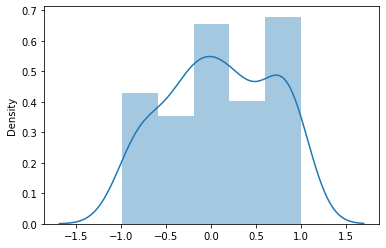

In [34]:
sns.distplot(F.cosine_similarity(A, B))

## Metric Learning

### Train embedding

Finally! Let's train! We instantiate a `Trainer` class that knows things like which hardware to work with, how long to train for, and a **bunch** of default options that we ignore here. Check out the Trainer class docs in Pytorch Lightning. Suffice it to say that it clears away much repetitive boilerplate in training code.

In [4]:
with open("example_super_embedding.yaml") as f:
    hparams = yaml.load(f, Loader=yaml.FullLoader)

In [5]:
model = UndirectedHalfTwinEmbedding(hparams)

In [6]:
model = DirectedHalfTwinEmbedding(hparams)

In [7]:
from pytorch_lightning.callbacks import ModelCheckpoint

checkpoint_callback = ModelCheckpoint(
    monitor="eff", mode="max", save_top_k=2, save_last=True
)

In [8]:
logger = WandbLogger(
    project=hparams["project"], group="InitialTest", save_dir=hparams["artifacts"]
)
trainer = Trainer(
    gpus=1,
    max_epochs=hparams["max_epochs"],
    logger=logger,
    num_sanity_val_steps=0,
    callbacks=[checkpoint_callback],
)
trainer.fit(model)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: murnanedaniel (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.12.6 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Set SLURM handle signals.

  | Name | Type       | Params
------------------------------------
0 | net1 | Sequential | 3.2 M 
1 | net2 | Sequential | 3.2 M 
------------------------------------
6.4 M     Trainable params
0         Non-trainable params
6.4 M     Total params
25.420    Total estimated model params size (MB)
/global/homes/d/danieltm/.conda/envs/exatrkx-test/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:106: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 80 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/global/homes/d/danieltm/.conda/envs/exatrkx-test/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:106: UserWarning: The dataloader, val dataloader 0, does not have many workers which

Training: -1it [00:00, ?it/s]

0.0
0.0
0.0
0.0
2.003916236062007
43.95174976772995
5.094516199649737
0.3623154024079236
0.35673550744698523
0.7263013212733883
0.8669497523000708
1.1049778472765182
6.698985901558249
52.61103803861735
75.89978909310034
83.41887327013185
86.25169288467549
86.47831866810154
85.66874600127959
72.71325742703834
59.98048917102315
51.23526751098475
49.14562804041412
58.01673058751598
78.31071260521776
87.2064307458143
89.26457978201353
90.68031654314784
93.08810024870863
94.68779523234099
96.43064876957494
97.4160314728301
97.99880209318454
98.55018456670769
98.64691622103386
98.82674599068805
98.75847172351885
99.28922645477915
99.18510732462934
98.81850147040021
99.26255789098681
99.31444787918714
99.0537230568256
98.91485692386306
99.17775006235969
99.25710064028895
98.82667790538405
99.04289790095781
98.9901640989612
99.10167813474581
99.10600977102831
99.23491565743944
99.11832248557043
99.38545627376426
99.36410590985702
99.3655357610689
99.44070701135918
99.50380691714356
99.49228148

Validating: 0it [00:00, ?it/s]

/global/homes/d/danieltm/.local/lib/python3.7/site-packages/ipykernel_launcher.py:100: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/global/homes/d/danieltm/.local/lib/python3.7/site-packages/ipykernel_launcher.py:101: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Efficiency: 0.055023759603500366
Purity: 0.0003698469663504511
Efficiency: 0.05345520004630089
Purity: 0.0003606640675570816
Efficiency: 0.047054681926965714
Purity: 0.00031633037724532187
Efficiency: 0.05635466426610947
Purity: 0.00038251306978054345
Efficiency: 0.05264194309711456
Purity: 0.00035756832221522927
Efficiency: 0.03748766705393791
Purity: 0.00025542068760842085
Efficiency: 0.0423409566283226
Purity: 0.0002889807219617069
Efficiency: 0.04143537953495979
Purity: 0.0002821250236593187
Efficiency: 0.05058188736438751
Purity: 0.0003455848782323301
Efficiency: 0.05700349435210228
Purity: 0.00038562805275432765
Efficiency: 0.05870717763900757
Purity: 0.00039780253428034484
Efficiency: 0.053171705454587936
Purity: 0.0003667317214421928
Efficiency: 0.05062362551689148
Purity: 0.0003438879793975502
Efficiency: 0.05959485098719597
Purity: 0.00040904953493736684
Efficiency: 0.04551491141319275
Purity: 0.00030304904794320464
Efficiency: 0.047402117401361465
Purity: 0.00031695916550233

Validating: 0it [00:00, ?it/s]

Efficiency: 0.046622134745121
Purity: 0.00031324595329351723
Efficiency: 0.05241656303405762
Purity: 0.00035349614336155355
Efficiency: 0.0444144569337368
Purity: 0.00029847779660485685
Efficiency: 0.0496838316321373
Purity: 0.00033709147828631103
Efficiency: 0.050016410648822784
Purity: 0.00033966300543397665
Efficiency: 0.03567905351519585
Purity: 0.00024302797100972384
Efficiency: 0.03661059960722923
Purity: 0.0002497808018233627
Efficiency: 0.039080459624528885
Purity: 0.0002660160243976861
Efficiency: 0.04622586444020271
Purity: 0.0003157410828862339
Efficiency: 0.051761794835329056
Purity: 0.0003499789163470268
Efficiency: 0.061397261917591095
Purity: 0.0004158677184022963
Efficiency: 0.04910806566476822
Purity: 0.00033858802635222673
Efficiency: 0.050757020711898804
Purity: 0.00034471589606255293
Efficiency: 0.05928077921271324
Purity: 0.0004066268738824874
Efficiency: 0.04279850423336029
Purity: 0.0002849086304195225
Efficiency: 0.04223097860813141
Purity: 0.0002823019749484956

Validating: 0it [00:00, ?it/s]

Efficiency: 0.14186351001262665
Purity: 0.000955131952650845
Efficiency: 0.1393158882856369
Purity: 0.0009413675870746374
Efficiency: 0.10989204049110413
Purity: 0.0007394475978799164
Efficiency: 0.13626572489738464
Purity: 0.0009276372147724032
Efficiency: 0.1317361295223236
Purity: 0.0008960885461419821
Efficiency: 0.10067959874868393
Purity: 0.0006866671028546989
Efficiency: 0.10107709467411041
Purity: 0.000690299435518682
Efficiency: 0.10630781948566437
Purity: 0.0007245269371196628
Efficiency: 0.13146089017391205
Purity: 0.0008992069633677602
Efficiency: 0.1472044289112091
Purity: 0.0009978266898542643
Efficiency: 0.1574491709470749
Purity: 0.0010686612222343683
Efficiency: 0.1383015364408493
Purity: 0.0009549749083817005
Efficiency: 0.13252851366996765
Purity: 0.0009014817187562585
Efficiency: 0.15774182975292206
Purity: 0.0010847515659406781
Efficiency: 0.11777134239673615
Purity: 0.000785111915320158
Efficiency: 0.12121398746967316
Purity: 0.0008114136871881783
Efficiency: 0.14

Validating: 0it [00:00, ?it/s]

Efficiency: 0.17312857508659363
Purity: 0.001167015521787107
Efficiency: 0.17594516277313232
Purity: 0.001190326758660376
Efficiency: 0.14574043452739716
Purity: 0.0009819490369409323
Efficiency: 0.17893128097057343
Purity: 0.0012183391954749823
Efficiency: 0.17203806340694427
Purity: 0.001172235468402505
Efficiency: 0.13465964794158936
Purity: 0.0009194447193294764
Efficiency: 0.12887993454933167
Purity: 0.00088146748021245
Efficiency: 0.14039810001850128
Purity: 0.0009580724872648716
Efficiency: 0.16403354704380035
Purity: 0.001123742084018886
Efficiency: 0.18571636080741882
Purity: 0.0012602627975866199
Efficiency: 0.2061872035264969
Purity: 0.0014020348899066448
Efficiency: 0.17466767132282257
Purity: 0.001208287081681192
Efficiency: 0.17027945816516876
Purity: 0.001160099171102047
Efficiency: 0.2017901986837387
Purity: 0.0013899998739361763
Efficiency: 0.1447543203830719
Purity: 0.0009662450756877661
Efficiency: 0.14743904769420624
Purity: 0.0009882883168756962
Efficiency: 0.19702

Validating: 0it [00:00, ?it/s]

Efficiency: 0.14606432616710663
Purity: 0.0009824492735788226
Efficiency: 0.13876193761825562
Purity: 0.0009368137107230723
Efficiency: 0.1097160279750824
Purity: 0.000737981463316828
Efficiency: 0.14196372032165527
Purity: 0.0009643989033065736
Efficiency: 0.13836561143398285
Purity: 0.0009406363824382424
Efficiency: 0.10533815622329712
Purity: 0.0007181594264693558
Efficiency: 0.10426062345504761
Purity: 0.0007119410438463092
Efficiency: 0.11309223622083664
Purity: 0.0007704857853241265
Efficiency: 0.13458162546157837
Purity: 0.0009201823850162327
Efficiency: 0.15572218596935272
Purity: 0.0010541266528889537
Efficiency: 0.16195902228355408
Purity: 0.0010982626117765903
Efficiency: 0.14112542569637299
Purity: 0.0009740504901856184
Efficiency: 0.13759754598140717
Purity: 0.0009354065987281501
Efficiency: 0.16025440394878387
Purity: 0.0011005745036527514
Efficiency: 0.11602076888084412
Purity: 0.0007730869110673666
Efficiency: 0.12423048168420792
Purity: 0.0008312089485116303
Efficiency

Validating: 0it [00:00, ?it/s]

Efficiency: 0.2559741139411926
Purity: 0.0017354334704577923
Efficiency: 0.24657249450683594
Purity: 0.0016778823919594288
Efficiency: 0.20335601270198822
Purity: 0.0013758373679593205
Efficiency: 0.24348551034927368
Purity: 0.0016713992226868868
Efficiency: 0.2395799160003662
Purity: 0.001639890717342496
Efficiency: 0.19319303333759308
Purity: 0.0013237179955467582
Efficiency: 0.18952618539333344
Purity: 0.0013006917433813214
Efficiency: 0.19843004643917084
Purity: 0.00135944620706141
Efficiency: 0.2289838045835495
Purity: 0.0015763354022055864
Efficiency: 0.2675451338291168
Purity: 0.0018270901637151837
Efficiency: 0.28372496366500854
Purity: 0.0019472514977678657
Efficiency: 0.2418210655450821
Purity: 0.0016821136232465506
Efficiency: 0.24037884175777435
Purity: 0.0016477341996505857
Efficiency: 0.2852543890476227
Purity: 0.001980195753276348
Efficiency: 0.21242304146289825
Purity: 0.0014230710221454501
Efficiency: 0.2152179330587387
Purity: 0.001448730006814003
Efficiency: 0.266185

Validating: 0it [00:00, ?it/s]

Efficiency: 0.0830521285533905
Purity: 0.0005749235861003399
Efficiency: 0.07935188710689545
Purity: 0.0005492996424436569
Efficiency: 0.06659235060214996
Purity: 0.0004588583833537996
Efficiency: 0.07567229866981506
Purity: 0.0005279106553643942
Efficiency: 0.07732195407152176
Purity: 0.0005381518858484924
Efficiency: 0.06395922601222992
Purity: 0.0004461358767002821
Efficiency: 0.0643603727221489
Purity: 0.0004496582841966301
Efficiency: 0.06790019571781158
Purity: 0.0004734785470645875
Efficiency: 0.0698264092206955
Purity: 0.0004900412750430405
Efficiency: 0.08248398452997208
Purity: 0.0005760515341535211
Efficiency: 0.08109819144010544
Purity: 0.0005687057855539024
Efficiency: 0.07142364978790283
Purity: 0.0005071095656603575
Efficiency: 0.0704328715801239
Purity: 0.0004928490379825234
Efficiency: 0.0820508822798729
Purity: 0.0005816545453853905
Efficiency: 0.07370518147945404
Purity: 0.0005034098867326975
Efficiency: 0.0695025846362114
Purity: 0.00047715328400954604
Efficiency: 0

Validating: 0it [00:00, ?it/s]

Efficiency: 0.2978444993495941
Purity: 0.002025785855948925
Efficiency: 0.29227253794670105
Purity: 0.0019950843416154385
Efficiency: 0.25134944915771484
Purity: 0.0017056707292795181
Efficiency: 0.2768397033214569
Purity: 0.0019064098596572876
Efficiency: 0.2862487733364105
Purity: 0.0019661015830934048
Efficiency: 0.23890167474746704
Purity: 0.0016427291557192802
Efficiency: 0.2367485612630844
Purity: 0.0016299388371407986
Efficiency: 0.2513596713542938
Purity: 0.0017267238581553102
Efficiency: 0.27351927757263184
Purity: 0.0018902156734839082
Efficiency: 0.30656668543815613
Purity: 0.0021020316053181887
Efficiency: 0.3242345154285431
Purity: 0.0022311329375952482
Efficiency: 0.287829726934433
Purity: 0.0020096099469810724
Efficiency: 0.2782631814479828
Purity: 0.0019132199231535196
Efficiency: 0.3246702253818512
Purity: 0.002261335961520672
Efficiency: 0.25208258628845215
Purity: 0.0016944915987551212
Efficiency: 0.2543708384037018
Purity: 0.001717604580335319
Efficiency: 0.29929369

Validating: 0it [00:00, ?it/s]

Efficiency: 0.17636527121067047
Purity: 0.0011905619176104665
Efficiency: 0.1764298528432846
Purity: 0.0011954465880990028
Efficiency: 0.14474302530288696
Purity: 0.0009757625521160662
Efficiency: 0.17309430241584778
Purity: 0.0011832560412585735
Efficiency: 0.17125040292739868
Purity: 0.0011671200627461076
Efficiency: 0.13559135794639587
Purity: 0.0009266254492104053
Efficiency: 0.1316920518875122
Purity: 0.0009011851507239044
Efficiency: 0.1427530199289322
Purity: 0.0009747465373948216
Efficiency: 0.16572394967079163
Purity: 0.001136214705184102
Efficiency: 0.18629877269268036
Purity: 0.0012672262964770198
Efficiency: 0.19107525050640106
Purity: 0.0013029536930844188
Efficiency: 0.17335905134677887
Purity: 0.0012002454604953527
Efficiency: 0.16561061143875122
Purity: 0.001129989279434085
Efficiency: 0.19590137898921967
Purity: 0.0013539231149479747
Efficiency: 0.14849692583084106
Purity: 0.0009915848495438695
Efficiency: 0.1525486260652542
Purity: 0.001023240969516337
Efficiency: 0.1

Validating: 0it [00:00, ?it/s]

Efficiency: 0.4348185360431671
Purity: 0.0030753135215491056
Efficiency: 0.4185708463191986
Purity: 0.0029803297948092222
Efficiency: 0.358718603849411
Purity: 0.0025161290541291237
Efficiency: 0.4072684347629547
Purity: 0.002921200357377529
Efficiency: 0.41430914402008057
Purity: 0.002961469814181328
Efficiency: 0.3448975086212158
Purity: 0.0024427659809589386
Efficiency: 0.3371358811855316
Purity: 0.0023855327162891626
Efficiency: 0.3494252860546112
Purity: 0.002477148314937949
Efficiency: 0.39724335074424744
Purity: 0.0028544412925839424
Efficiency: 0.44576296210289
Purity: 0.0031937500461935997
Efficiency: 0.45628610253334045
Purity: 0.0032932136673480272
Efficiency: 0.4186238646507263
Purity: 0.0030510348733514547
Efficiency: 0.4015873968601227
Purity: 0.0028690542094409466
Efficiency: 0.4579145610332489
Purity: 0.0033521943259984255
Efficiency: 0.3654473125934601
Purity: 0.00253892270848155
Efficiency: 0.3675203025341034
Purity: 0.002567559713497758
Efficiency: 0.4370217919349670

Validating: 0it [00:00, ?it/s]

Efficiency: 0.17092487215995789
Purity: 0.0018434836529195309
Efficiency: 0.15683422982692719
Purity: 0.0017524638678878546
Efficiency: 0.1340060979127884
Purity: 0.001418328727595508
Efficiency: 0.15301230549812317
Purity: 0.0016841184115037322
Efficiency: 0.15484082698822021
Purity: 0.0016970441211014986
Efficiency: 0.1359201967716217
Purity: 0.0014189331559464335
Efficiency: 0.1317981630563736
Purity: 0.0013723158044740558
Efficiency: 0.13641715049743652
Purity: 0.0014562888536602259
Efficiency: 0.15668682754039764
Purity: 0.0016973265446722507
Efficiency: 0.16897204518318176
Purity: 0.0018771786708384752
Efficiency: 0.16282933950424194
Purity: 0.0018913928652182221
Efficiency: 0.15779323875904083
Purity: 0.0017748614773154259
Efficiency: 0.15180417895317078
Purity: 0.0016744860913604498
Efficiency: 0.16260991990566254
Purity: 0.001896388130262494
Efficiency: 0.14650489389896393
Purity: 0.001511745504103601
Efficiency: 0.14947056770324707
Purity: 0.001555805909447372
Efficiency: 0.1

Validating: 0it [00:00, ?it/s]

Efficiency: 0.4253150522708893
Purity: 0.003020910080522299
Efficiency: 0.40894612669944763
Purity: 0.0029380396008491516
Efficiency: 0.3425252139568329
Purity: 0.0024128821678459644
Efficiency: 0.39774858951568604
Purity: 0.002871694741770625
Efficiency: 0.3939612805843353
Purity: 0.0028321619611233473
Efficiency: 0.33103147149086
Purity: 0.002345355926081538
Efficiency: 0.3153817653656006
Purity: 0.002237176988273859
Efficiency: 0.33742639422416687
Purity: 0.0023949560709297657
Efficiency: 0.39301735162734985
Purity: 0.0028369720093905926
Efficiency: 0.44285091757774353
Purity: 0.0031930534169077873
Efficiency: 0.43880054354667664
Purity: 0.0032233991660177708
Efficiency: 0.40257593989372253
Purity: 0.0029630193021148443
Efficiency: 0.3915160298347473
Purity: 0.00282232160679996
Efficiency: 0.4430747628211975
Purity: 0.0032857253681868315
Efficiency: 0.36001449823379517
Purity: 0.002502353861927986
Efficiency: 0.36579659581184387
Purity: 0.0025617689825594425
Efficiency: 0.4195114672

Validating: 0it [00:00, ?it/s]

Efficiency: 0.7014668583869934
Purity: 0.005528709385544062
Efficiency: 0.6803074479103088
Purity: 0.005428014788776636
Efficiency: 0.6239732503890991
Purity: 0.0047853565774858
Efficiency: 0.6566604375839233
Purity: 0.005266172811388969
Efficiency: 0.6725959777832031
Purity: 0.005353368353098631
Efficiency: 0.6080784797668457
Purity: 0.004660358652472496
Efficiency: 0.5930917263031006
Purity: 0.004541268106549978
Efficiency: 0.6135127544403076
Purity: 0.004741589538753033
Efficiency: 0.6614654660224915
Purity: 0.005283542443066835
Efficiency: 0.7069743871688843
Purity: 0.005693844519555569
Efficiency: 0.7068597078323364
Purity: 0.0058453017845749855
Efficiency: 0.6852400302886963
Purity: 0.005610374268144369
Efficiency: 0.6656439900398254
Purity: 0.005284914281219244
Efficiency: 0.7151381969451904
Purity: 0.00601481506600976
Efficiency: 0.6346734166145325
Purity: 0.00482405349612236
Efficiency: 0.6321102976799011
Purity: 0.004841623827815056
Efficiency: 0.694526195526123
Purity: 0.005

Validating: 0it [00:00, ?it/s]

Efficiency: 0.756146252155304
Purity: 0.0063096811063587666
Efficiency: 0.7206758260726929
Purity: 0.006079940125346184
Efficiency: 0.6596456170082092
Purity: 0.005290387663990259
Efficiency: 0.7139184474945068
Purity: 0.006041848566383123
Efficiency: 0.7220216393470764
Purity: 0.006062469910830259
Efficiency: 0.6523073315620422
Purity: 0.005191483534872532
Efficiency: 0.63421231508255
Purity: 0.005043162032961845
Efficiency: 0.6528735756874084
Purity: 0.005258926656097174
Efficiency: 0.7047005891799927
Purity: 0.005914292763918638
Efficiency: 0.7600466012954712
Purity: 0.006532708648592234
Efficiency: 0.7577340006828308
Purity: 0.0067386808805167675
Efficiency: 0.7259452939033508
Purity: 0.006285002920776606
Efficiency: 0.7190021872520447
Purity: 0.006029737181961536
Efficiency: 0.7562814354896545
Purity: 0.006821534596383572
Efficiency: 0.6827840209007263
Purity: 0.005420525558292866
Efficiency: 0.6847451329231262
Purity: 0.005488898139446974
Efficiency: 0.7513242959976196
Purity: 0.

Validating: 0it [00:00, ?it/s]

Efficiency: 0.8058673739433289
Purity: 0.0071659698151052
Efficiency: 0.7767622470855713
Purity: 0.006967243272811174
Efficiency: 0.7338066101074219
Purity: 0.006136284675449133
Efficiency: 0.7746508121490479
Purity: 0.006936355959624052
Efficiency: 0.7795864939689636
Purity: 0.0069219982251524925
Efficiency: 0.731338381767273
Purity: 0.0060716005973517895
Efficiency: 0.7113068103790283
Purity: 0.005867703352123499
Efficiency: 0.7319315671920776
Purity: 0.006120162084698677
Efficiency: 0.7704960703849792
Purity: 0.00687395827844739
Efficiency: 0.8095515370368958
Purity: 0.007457411382347345
Efficiency: 0.8070258498191833
Purity: 0.007733858190476894
Efficiency: 0.7887595295906067
Purity: 0.007282420992851257
Efficiency: 0.772693932056427
Purity: 0.006860343273729086
Efficiency: 0.8120288848876953
Purity: 0.007906395010650158
Efficiency: 0.7542557120323181
Purity: 0.006269144359976053
Efficiency: 0.7613888382911682
Purity: 0.00640117609873414
Efficiency: 0.8036344647407532
Purity: 0.007

Validating: 0it [00:00, ?it/s]

Efficiency: 0.8388540744781494
Purity: 0.008443618193268776
Efficiency: 0.8252319693565369
Purity: 0.00831492617726326
Efficiency: 0.7876085638999939
Purity: 0.007205640431493521
Efficiency: 0.8084219098091125
Purity: 0.008099110797047615
Efficiency: 0.8137840628623962
Purity: 0.008107624016702175
Efficiency: 0.7874602675437927
Purity: 0.007112571969628334
Efficiency: 0.7717939019203186
Purity: 0.006881846114993095
Efficiency: 0.7777964472770691
Purity: 0.007149056065827608
Efficiency: 0.8036538362503052
Purity: 0.008010285906493664
Efficiency: 0.8367792367935181
Purity: 0.008812720887362957
Efficiency: 0.8436585068702698
Purity: 0.009233097545802593
Efficiency: 0.8229216933250427
Purity: 0.008593439124524593
Efficiency: 0.8182485103607178
Purity: 0.008092113770544529
Efficiency: 0.834013819694519
Purity: 0.009363342076539993
Efficiency: 0.7979596853256226
Purity: 0.007321205455809832
Efficiency: 0.799187421798706
Purity: 0.00745405675843358
Efficiency: 0.8332842588424683
Purity: 0.008

Validating: 0it [00:00, ?it/s]

Efficiency: 0.6359754800796509
Purity: 0.008763322606682777
Efficiency: 0.6251904368400574
Purity: 0.008576161228120327
Efficiency: 0.6144684553146362
Purity: 0.0073251440189778805
Efficiency: 0.6127440929412842
Purity: 0.008362550288438797
Efficiency: 0.6264522671699524
Purity: 0.008376926183700562
Efficiency: 0.6365230679512024
Purity: 0.007451721467077732
Efficiency: 0.6210537552833557
Purity: 0.007127403747290373
Efficiency: 0.6103728413581848
Purity: 0.007324868813157082
Efficiency: 0.6313633918762207
Purity: 0.00834889430552721
Efficiency: 0.6357018351554871
Purity: 0.009254725649952888
Efficiency: 0.6227549910545349
Purity: 0.009573375806212425
Efficiency: 0.634754478931427
Purity: 0.008979393169283867
Efficiency: 0.6175548434257507
Purity: 0.008294506929814816
Efficiency: 0.6297895908355713
Purity: 0.009816808626055717
Efficiency: 0.6219365000724792
Purity: 0.007579787168651819
Efficiency: 0.6251538991928101
Purity: 0.007765506859868765
Efficiency: 0.6256621479988098
Purity: 0.

Validating: 0it [00:00, ?it/s]

Efficiency: 0.8724606037139893
Purity: 0.010457301512360573
Efficiency: 0.8536906242370605
Purity: 0.010196064598858356
Efficiency: 0.8303215503692627
Purity: 0.008710070513188839
Efficiency: 0.8549093008041382
Purity: 0.010150512680411339
Efficiency: 0.8517230153083801
Purity: 0.009968035854399204
Efficiency: 0.8478022813796997
Purity: 0.008735782466828823
Efficiency: 0.8292566537857056
Purity: 0.008383573032915592
Efficiency: 0.8311746716499329
Purity: 0.008726468309760094
Efficiency: 0.8559261560440063
Purity: 0.009925908409059048
Efficiency: 0.8728887438774109
Purity: 0.010979531332850456
Efficiency: 0.8647044897079468
Purity: 0.01143113523721695
Efficiency: 0.864935576915741
Purity: 0.010661736130714417
Efficiency: 0.8523311018943787
Purity: 0.009961351752281189
Efficiency: 0.8640075325965881
Purity: 0.011709173209965229
Efficiency: 0.8469757437705994
Purity: 0.009014646522700787
Efficiency: 0.8492366671562195
Purity: 0.009214727208018303
Efficiency: 0.86631840467453
Purity: 0.011

Validating: 0it [00:00, ?it/s]

Efficiency: 0.8194339275360107
Purity: 0.011581831611692905
Efficiency: 0.8067442178726196
Purity: 0.011386524885892868
Efficiency: 0.797582745552063
Purity: 0.009691108949482441
Efficiency: 0.804947555065155
Purity: 0.011276643723249435
Efficiency: 0.8068264126777649
Purity: 0.011067931540310383
Efficiency: 0.8157404065132141
Purity: 0.00974970031529665
Efficiency: 0.8032578229904175
Purity: 0.009333734400570393
Efficiency: 0.7904121279716492
Purity: 0.00961806159466505
Efficiency: 0.8095702528953552
Purity: 0.010984261520206928
Efficiency: 0.8186517357826233
Purity: 0.012166700325906277
Efficiency: 0.8089247345924377
Purity: 0.012726500630378723
Efficiency: 0.8161030411720276
Purity: 0.01188741996884346
Efficiency: 0.8035749793052673
Purity: 0.011095485650002956
Efficiency: 0.809202253818512
Purity: 0.013091206550598145
Efficiency: 0.8062899708747864
Purity: 0.010032636113464832
Efficiency: 0.8026964068412781
Purity: 0.010231874883174896
Efficiency: 0.8115803599357605
Purity: 0.01238

Validating: 0it [00:00, ?it/s]

Efficiency: 0.9207354784011841
Purity: 0.012637624517083168
Efficiency: 0.9065918922424316
Purity: 0.012479983270168304
Efficiency: 0.896679162979126
Purity: 0.01061702799052
Efficiency: 0.9077200889587402
Purity: 0.012286978773772717
Efficiency: 0.9057433605194092
Purity: 0.012039604596793652
Efficiency: 0.8976213932037354
Purity: 0.010395449586212635
Efficiency: 0.8875682950019836
Purity: 0.010029390454292297
Efficiency: 0.8886459469795227
Purity: 0.010545499622821808
Efficiency: 0.9096287488937378
Purity: 0.011910295113921165
Efficiency: 0.9173704385757446
Purity: 0.01324094831943512
Efficiency: 0.9172402620315552
Purity: 0.014089162461459637
Efficiency: 0.9166609048843384
Purity: 0.012891321443021297
Efficiency: 0.9108917713165283
Purity: 0.01225974503904581
Efficiency: 0.915986180305481
Purity: 0.014299372211098671
Efficiency: 0.9016057252883911
Purity: 0.010844807140529156
Efficiency: 0.9056267142295837
Purity: 0.011102155782282352
Efficiency: 0.9144349694252014
Purity: 0.0134713

Validating: 0it [00:00, ?it/s]

Efficiency: 0.8889883756637573
Purity: 0.013462173752486706
Efficiency: 0.8691316843032837
Purity: 0.013310865499079227
Efficiency: 0.8694555163383484
Purity: 0.011187300086021423
Efficiency: 0.8722813129425049
Purity: 0.012857253663241863
Efficiency: 0.877518892288208
Purity: 0.012834605760872364
Efficiency: 0.8795352578163147
Purity: 0.011059158481657505
Efficiency: 0.8677242994308472
Purity: 0.010683714412152767
Efficiency: 0.8600504398345947
Purity: 0.011035450734198093
Efficiency: 0.8767310380935669
Purity: 0.012664100155234337
Efficiency: 0.8859930038452148
Purity: 0.014153302647173405
Efficiency: 0.8810032606124878
Purity: 0.015081148594617844
Efficiency: 0.8787795305252075
Purity: 0.013803198002278805
Efficiency: 0.8797438740730286
Purity: 0.013035155832767487
Efficiency: 0.8779836893081665
Purity: 0.015337557531893253
Efficiency: 0.8740190863609314
Purity: 0.011482548899948597
Efficiency: 0.8742920756340027
Purity: 0.011689553037285805
Efficiency: 0.8827987313270569
Purity: 0.

Validating: 0it [00:00, ?it/s]

Efficiency: 0.9221816658973694
Purity: 0.014948699623346329
Efficiency: 0.9074920415878296
Purity: 0.014878692105412483
Efficiency: 0.9065946936607361
Purity: 0.012473905459046364
Efficiency: 0.9114724397659302
Purity: 0.014479762874543667
Efficiency: 0.9091565608978271
Purity: 0.014156164601445198
Efficiency: 0.9153786897659302
Purity: 0.012250463478267193
Efficiency: 0.9068287014961243
Purity: 0.011881712824106216
Efficiency: 0.9005887508392334
Purity: 0.012311338447034359
Efficiency: 0.9156101942062378
Purity: 0.014070463366806507
Efficiency: 0.9194088578224182
Purity: 0.015681477263569832
Efficiency: 0.9125722050666809
Purity: 0.016661467030644417
Efficiency: 0.9175562858581543
Purity: 0.015381009317934513
Efficiency: 0.9094244241714478
Purity: 0.014344885013997555
Efficiency: 0.9109610319137573
Purity: 0.016999242827296257
Efficiency: 0.9093927145004272
Purity: 0.01278605218976736
Efficiency: 0.9084585309028625
Purity: 0.013004489243030548
Efficiency: 0.9182607531547546
Purity: 0.

Validating: 0it [00:00, ?it/s]

Efficiency: 0.9267956614494324
Purity: 0.016359208151698112
Efficiency: 0.9167705178260803
Purity: 0.016368595883250237
Efficiency: 0.9163342118263245
Purity: 0.013617685064673424
Efficiency: 0.9193940758705139
Purity: 0.015962406992912292
Efficiency: 0.9163767695426941
Purity: 0.015516135841608047
Efficiency: 0.9198728203773499
Purity: 0.013340645469725132
Efficiency: 0.9172812700271606
Purity: 0.012945681810379028
Efficiency: 0.9169049859046936
Purity: 0.013582722283899784
Efficiency: 0.9245172739028931
Purity: 0.015454908832907677
Efficiency: 0.9255241751670837
Purity: 0.017203815281391144
Efficiency: 0.9170820713043213
Purity: 0.018352821469306946
Efficiency: 0.9243749380111694
Purity: 0.016851428896188736
Efficiency: 0.9147602319717407
Purity: 0.015738390386104584
Efficiency: 0.9216394424438477
Purity: 0.018633579835295677
Efficiency: 0.9168176054954529
Purity: 0.013974227011203766
Efficiency: 0.9181851744651794
Purity: 0.014284332282841206
Efficiency: 0.9239994287490845
Purity: 0

Validating: 0it [00:00, ?it/s]

Efficiency: 0.8874044418334961
Purity: 0.01593799889087677
Efficiency: 0.8744633793830872
Purity: 0.015919435769319534
Efficiency: 0.8752053380012512
Purity: 0.013260415755212307
Efficiency: 0.871308445930481
Purity: 0.015403987839818
Efficiency: 0.8741713166236877
Purity: 0.01502198912203312
Efficiency: 0.8817822933197021
Purity: 0.012990525923669338
Efficiency: 0.8753647804260254
Purity: 0.012638600543141365
Efficiency: 0.8717690110206604
Purity: 0.013112486340105534
Efficiency: 0.8797867298126221
Purity: 0.014976448379456997
Efficiency: 0.884027361869812
Purity: 0.016776803880929947
Efficiency: 0.8757022023200989
Purity: 0.017832888290286064
Efficiency: 0.8810524344444275
Purity: 0.016391614452004433
Efficiency: 0.8744747638702393
Purity: 0.015298913232982159
Efficiency: 0.8756281137466431
Purity: 0.01823604851961136
Efficiency: 0.8781238794326782
Purity: 0.013581517152488232
Efficiency: 0.8773701190948486
Purity: 0.01383340172469616
Efficiency: 0.8796350955963135
Purity: 0.01716807

Validating: 0it [00:00, ?it/s]

Efficiency: 0.9242476224899292
Purity: 0.018041452392935753
Efficiency: 0.9122697710990906
Purity: 0.018147682771086693
Efficiency: 0.9136939644813538
Purity: 0.014923828653991222
Efficiency: 0.9168925285339355
Purity: 0.017607254907488823
Efficiency: 0.9140138030052185
Purity: 0.017044834792613983
Efficiency: 0.920366108417511
Purity: 0.014600539579987526
Efficiency: 0.9154242277145386
Purity: 0.014205319806933403
Efficiency: 0.9113540649414062
Purity: 0.014748582616448402
Efficiency: 0.921266496181488
Purity: 0.017088595777750015
Efficiency: 0.922248125076294
Purity: 0.01901339925825596
Efficiency: 0.9148666858673096
Purity: 0.02029472403228283
Efficiency: 0.9212067127227783
Purity: 0.018694188445806503
Efficiency: 0.9122924208641052
Purity: 0.01740347407758236
Efficiency: 0.9187343120574951
Purity: 0.020660988986492157
Efficiency: 0.9141011834144592
Purity: 0.015330957248806953
Efficiency: 0.9149839878082275
Purity: 0.015676848590373993
Efficiency: 0.9201736450195312
Purity: 0.01950

Validating: 0it [00:00, ?it/s]

Efficiency: 0.9520005583763123
Purity: 0.018610937520861626
Efficiency: 0.9460601210594177
Purity: 0.018853552639484406
Efficiency: 0.9453766942024231
Purity: 0.015536936931312084
Efficiency: 0.9475366473197937
Purity: 0.01827860064804554
Efficiency: 0.9461109042167664
Purity: 0.01769012212753296
Efficiency: 0.9501808881759644
Purity: 0.015147067606449127
Efficiency: 0.9443413019180298
Purity: 0.014726836234331131
Efficiency: 0.9465657472610474
Purity: 0.015396415255963802
Efficiency: 0.9511085152626038
Purity: 0.01768316514790058
Efficiency: 0.9512958526611328
Purity: 0.019607285037636757
Efficiency: 0.9440620541572571
Purity: 0.020971449092030525
Efficiency: 0.9512363076210022
Purity: 0.01930115558207035
Efficiency: 0.9439071416854858
Purity: 0.017987307161092758
Efficiency: 0.9502198696136475
Purity: 0.02143206261098385
Efficiency: 0.9445249438285828
Purity: 0.015875447541475296
Efficiency: 0.9461339712142944
Purity: 0.016231132671236992
Efficiency: 0.9482048153877258
Purity: 0.0202

Validating: 0it [00:00, ?it/s]

Efficiency: 0.9544108510017395
Purity: 0.019178662449121475
Efficiency: 0.949106752872467
Purity: 0.019482292234897614
Efficiency: 0.9492490291595459
Purity: 0.015990329906344414
Efficiency: 0.9508720636367798
Purity: 0.018898073583841324
Efficiency: 0.9476862549781799
Purity: 0.018241429701447487
Efficiency: 0.9536336660385132
Purity: 0.015603603795170784
Efficiency: 0.9477370381355286
Purity: 0.015165923163294792
Efficiency: 0.9492570757865906
Purity: 0.01582210510969162
Efficiency: 0.9524087905883789
Purity: 0.01823357492685318
Efficiency: 0.953843891620636
Purity: 0.020232561975717545
Efficiency: 0.9470685720443726
Purity: 0.021673711016774178
Efficiency: 0.951511800289154
Purity: 0.019876381382346153
Efficiency: 0.9463082551956177
Purity: 0.01858135685324669
Efficiency: 0.9515546560287476
Purity: 0.0220615416765213
Efficiency: 0.9473620653152466
Purity: 0.016386408358812332
Efficiency: 0.9492120146751404
Purity: 0.016750970855355263
Efficiency: 0.9510741829872131
Purity: 0.0208193

Validating: 0it [00:00, ?it/s]

Efficiency: 0.9504855275154114
Purity: 0.018866170197725296
Efficiency: 0.941490113735199
Purity: 0.01906932331621647
Efficiency: 0.9440858960151672
Purity: 0.015733610838651657
Efficiency: 0.9421166181564331
Purity: 0.018496563658118248
Efficiency: 0.9403347373008728
Purity: 0.017806537449359894
Efficiency: 0.9467828273773193
Purity: 0.015322322957217693
Efficiency: 0.9403618574142456
Purity: 0.014902832917869091
Efficiency: 0.9415755271911621
Purity: 0.015466314740478992
Efficiency: 0.9451271295547485
Purity: 0.01784493401646614
Efficiency: 0.9481654167175293
Purity: 0.019873743876814842
Efficiency: 0.9393148422241211
Purity: 0.021195458248257637
Efficiency: 0.9468971490859985
Purity: 0.019529879093170166
Efficiency: 0.9391049146652222
Purity: 0.018176959827542305
Efficiency: 0.9470791220664978
Purity: 0.021720653399825096
Efficiency: 0.9405408501625061
Purity: 0.01605537161231041
Efficiency: 0.941270649433136
Purity: 0.01641857996582985
Efficiency: 0.94364333152771
Purity: 0.0203712

Validating: 0it [00:00, ?it/s]

Efficiency: 0.9598512649536133
Purity: 0.019640779122710228
Efficiency: 0.9542307257652283
Purity: 0.019911661744117737
Efficiency: 0.9545294642448425
Purity: 0.016369162127375603
Efficiency: 0.9551108479499817
Purity: 0.019413841888308525
Efficiency: 0.9517558217048645
Purity: 0.018679765984416008
Efficiency: 0.9582922458648682
Purity: 0.015964027494192123
Efficiency: 0.9523531794548035
Purity: 0.015526024624705315
Efficiency: 0.9540790319442749
Purity: 0.0161583311855793
Efficiency: 0.9566998481750488
Purity: 0.018712565302848816
Efficiency: 0.9588671922683716
Purity: 0.020747089758515358
Efficiency: 0.9514201879501343
Purity: 0.022165898233652115
Efficiency: 0.9563331007957458
Purity: 0.020348377525806427
Efficiency: 0.9505769610404968
Purity: 0.018995903432369232
Efficiency: 0.957600474357605
Purity: 0.022677913308143616
Efficiency: 0.9533985257148743
Purity: 0.016784146428108215
Efficiency: 0.9538291096687317
Purity: 0.017157068476080894
Efficiency: 0.9554149508476257
Purity: 0.02

Validating: 0it [00:00, ?it/s]

Efficiency: 0.9566145539283752
Purity: 0.019713835790753365
Efficiency: 0.950145423412323
Purity: 0.019979150965809822
Efficiency: 0.9496010541915894
Purity: 0.016393626108765602
Efficiency: 0.9497602581977844
Purity: 0.019506486132740974
Efficiency: 0.9482769966125488
Purity: 0.01874561235308647
Efficiency: 0.9564288258552551
Purity: 0.016062656417489052
Efficiency: 0.9475778341293335
Purity: 0.015550659969449043
Efficiency: 0.9512755870819092
Purity: 0.016203418374061584
Efficiency: 0.9516936540603638
Purity: 0.01877441629767418
Efficiency: 0.9553727507591248
Purity: 0.02082235924899578
Efficiency: 0.9486510157585144
Purity: 0.022296937182545662
Efficiency: 0.9534403085708618
Purity: 0.02044786512851715
Efficiency: 0.9469085335731506
Purity: 0.01909787766635418
Efficiency: 0.9549309015274048
Purity: 0.022789107635617256
Efficiency: 0.9506821036338806
Purity: 0.016843995079398155
Efficiency: 0.9506894946098328
Purity: 0.01720760576426983
Efficiency: 0.9507063031196594
Purity: 0.021361

Validating: 0it [00:00, ?it/s]

Efficiency: 0.9617106318473816
Purity: 0.020503144711256027
Efficiency: 0.9567234516143799
Purity: 0.020821277052164078
Efficiency: 0.9562309384346008
Purity: 0.017086006700992584
Efficiency: 0.9572649598121643
Purity: 0.02025521919131279
Efficiency: 0.9548408389091492
Purity: 0.01948104053735733
Efficiency: 0.9607585072517395
Purity: 0.01668247953057289
Efficiency: 0.9539449214935303
Purity: 0.016204727813601494
Efficiency: 0.9559293389320374
Purity: 0.01685050129890442
Efficiency: 0.9587802886962891
Purity: 0.019512318074703217
Efficiency: 0.9602504372596741
Purity: 0.021618450060486794
Efficiency: 0.9526861310005188
Purity: 0.023113321512937546
Efficiency: 0.958743691444397
Purity: 0.021267298609018326
Efficiency: 0.9528446793556213
Purity: 0.019841253757476807
Efficiency: 0.9588567614555359
Purity: 0.023610111325979233
Efficiency: 0.9553905725479126
Purity: 0.017524395138025284
Efficiency: 0.9563531279563904
Purity: 0.01789410598576069
Efficiency: 0.9574750065803528
Purity: 0.02227

Validating: 0it [00:00, ?it/s]

Efficiency: 0.9641209244728088
Purity: 0.021055258810520172
Efficiency: 0.9592854380607605
Purity: 0.021397724747657776
Efficiency: 0.9594578742980957
Purity: 0.01761351153254509
Efficiency: 0.9593495726585388
Purity: 0.02094506099820137
Efficiency: 0.9565474390983582
Purity: 0.020045971497893333
Efficiency: 0.9624027013778687
Purity: 0.01716265082359314
Efficiency: 0.9582957625389099
Purity: 0.016762789338827133
Efficiency: 0.9601345658302307
Purity: 0.017396092414855957
Efficiency: 0.961901068687439
Purity: 0.020074108615517616
Efficiency: 0.9627984762191772
Purity: 0.022200139239430428
Efficiency: 0.9575915932655334
Purity: 0.023894699290394783
Efficiency: 0.9613609910011292
Purity: 0.02186557650566101
Efficiency: 0.9563129544258118
Purity: 0.020491434261202812
Efficiency: 0.9627826809883118
Purity: 0.024224918335676193
Efficiency: 0.9579258561134338
Purity: 0.018060270696878433
Efficiency: 0.958323061466217
Purity: 0.018372217193245888
Efficiency: 0.9598293304443359
Purity: 0.02296

Validating: 0it [00:00, ?it/s]

Efficiency: 0.9615728855133057
Purity: 0.02082199417054653
Efficiency: 0.9558925628662109
Purity: 0.02116730622947216
Efficiency: 0.9565243124961853
Purity: 0.017395488917827606
Efficiency: 0.9558752179145813
Purity: 0.02066647820174694
Efficiency: 0.9526747465133667
Purity: 0.019780093804001808
Efficiency: 0.9602652788162231
Purity: 0.01696692779660225
Efficiency: 0.9529898762702942
Purity: 0.016512643545866013
Efficiency: 0.9568264484405518
Purity: 0.017147788777947426
Efficiency: 0.957349956035614
Purity: 0.01988660916686058
Efficiency: 0.9598864316940308
Purity: 0.02198038436472416
Efficiency: 0.9537938237190247
Purity: 0.023570885881781578
Efficiency: 0.9583993554115295
Purity: 0.021679958328604698
Efficiency: 0.9522444009780884
Purity: 0.02019166387617588
Efficiency: 0.9579930901527405
Purity: 0.02401946671307087
Efficiency: 0.9546058177947998
Purity: 0.01781616173684597
Efficiency: 0.9550603032112122
Purity: 0.018185099586844444
Efficiency: 0.9558563828468323
Purity: 0.022611692

Validating: 0it [00:00, ?it/s]

Efficiency: 0.9642586708068848
Purity: 0.02235916070640087
Efficiency: 0.9590084552764893
Purity: 0.022814126685261726
Efficiency: 0.958695113658905
Purity: 0.01874031499028206
Efficiency: 0.9580293297767639
Purity: 0.022349854931235313
Efficiency: 0.955628514289856
Purity: 0.021358687430620193
Efficiency: 0.9619642496109009
Purity: 0.01827925816178322
Efficiency: 0.9574998617172241
Purity: 0.017835205420851707
Efficiency: 0.9586767554283142
Purity: 0.018500685691833496
Efficiency: 0.959495484828949
Purity: 0.021354764699935913
Efficiency: 0.9627256989479065
Purity: 0.02362968772649765
Efficiency: 0.9565629959106445
Purity: 0.025421911850571632
Efficiency: 0.9594324827194214
Purity: 0.023240527138113976
Efficiency: 0.9550457000732422
Purity: 0.02182009443640709
Efficiency: 0.960898220539093
Purity: 0.02567615546286106
Efficiency: 0.9549680352210999
Purity: 0.019184524193406105
Efficiency: 0.9556759595870972
Purity: 0.019565682858228683
Efficiency: 0.9575485587120056
Purity: 0.024419806

Validating: 0it [00:00, ?it/s]

Efficiency: 0.9586116671562195
Purity: 0.021304013207554817
Efficiency: 0.9534690380096436
Purity: 0.021672513335943222
Efficiency: 0.9537667036056519
Purity: 0.017811866477131844
Efficiency: 0.9545549154281616
Purity: 0.021253881976008415
Efficiency: 0.9506399631500244
Purity: 0.020292215049266815
Efficiency: 0.9593335390090942
Purity: 0.017428725957870483
Efficiency: 0.950814425945282
Purity: 0.016918955370783806
Efficiency: 0.9550883173942566
Purity: 0.017576606944203377
Efficiency: 0.9548143744468689
Purity: 0.020417071878910065
Efficiency: 0.9567559957504272
Purity: 0.022520778700709343
Efficiency: 0.9503916501998901
Purity: 0.024128427729010582
Efficiency: 0.9557820558547974
Purity: 0.022212795913219452
Efficiency: 0.9490429162979126
Purity: 0.02069772034883499
Efficiency: 0.9557945728302002
Purity: 0.02460693195462227
Efficiency: 0.9533381462097168
Purity: 0.01828022487461567
Efficiency: 0.9540753364562988
Purity: 0.018663790076971054
Efficiency: 0.9523248672485352
Purity: 0.023

Validating: 0it [00:00, ?it/s]

Efficiency: 0.963019073009491
Purity: 0.021959420293569565
Efficiency: 0.9575543403625488
Purity: 0.02234928496181965
Efficiency: 0.9574630260467529
Purity: 0.01835402101278305
Efficiency: 0.9577513933181763
Purity: 0.021884864196181297
Efficiency: 0.9540531635284424
Purity: 0.02091267518699169
Efficiency: 0.9619094729423523
Purity: 0.017915308475494385
Efficiency: 0.9555366635322571
Purity: 0.01745760254561901
Efficiency: 0.9601906538009644
Purity: 0.01815725862979889
Efficiency: 0.9602756500244141
Purity: 0.021013455465435982
Efficiency: 0.9611968398094177
Purity: 0.023201990872621536
Efficiency: 0.9545850157737732
Purity: 0.024908026680350304
Efficiency: 0.9604656100273132
Purity: 0.022879334166646004
Efficiency: 0.9537784457206726
Purity: 0.021325809881091118
Efficiency: 0.9605056643486023
Purity: 0.025303024798631668
Efficiency: 0.9561149477958679
Purity: 0.018856782466173172
Efficiency: 0.9565993547439575
Purity: 0.01918589323759079
Efficiency: 0.9570335745811462
Purity: 0.023922

Validating: 0it [00:00, ?it/s]

Efficiency: 0.9677019715309143
Purity: 0.022976702079176903
Efficiency: 0.9620551466941833
Purity: 0.023400183767080307
Efficiency: 0.9623327851295471
Purity: 0.019261391833424568
Efficiency: 0.9629629850387573
Purity: 0.022994723170995712
Efficiency: 0.960551381111145
Purity: 0.021969541907310486
Efficiency: 0.9651430249214172
Purity: 0.018776750192046165
Efficiency: 0.9605773091316223
Purity: 0.01834048144519329
Efficiency: 0.9623773694038391
Purity: 0.019009919837117195
Efficiency: 0.964176595211029
Purity: 0.021954433992505074
Efficiency: 0.9654921293258667
Purity: 0.02424594759941101
Efficiency: 0.9590157270431519
Purity: 0.026049133390188217
Efficiency: 0.9630140066146851
Purity: 0.023875020444393158
Efficiency: 0.9567798376083374
Purity: 0.022330844774842262
Efficiency: 0.9646670818328857
Purity: 0.026374144479632378
Efficiency: 0.96058189868927
Purity: 0.01974334754049778
Efficiency: 0.961401104927063
Purity: 0.020126815885305405
Efficiency: 0.9624043703079224
Purity: 0.0251177

Validating: 0it [00:00, ?it/s]

Efficiency: 0.9657048583030701
Purity: 0.023071544244885445
Efficiency: 0.9614319205284119
Purity: 0.023617038503289223
Efficiency: 0.9604552984237671
Purity: 0.01934037171304226
Efficiency: 0.9606003761291504
Purity: 0.023076653480529785
Efficiency: 0.9560879468917847
Purity: 0.022049350664019585
Efficiency: 0.9638276696205139
Purity: 0.018906831741333008
Efficiency: 0.9574998617172241
Purity: 0.01839727722108364
Efficiency: 0.9623212814331055
Purity: 0.0191540215164423
Efficiency: 0.962486207485199
Purity: 0.022161046043038368
Efficiency: 0.9634537100791931
Purity: 0.02440360188484192
Efficiency: 0.957908034324646
Purity: 0.02623453177511692
Efficiency: 0.9621186256408691
Purity: 0.024073608219623566
Efficiency: 0.9559127688407898
Purity: 0.022464865818619728
Efficiency: 0.9619189500808716
Purity: 0.02659953199326992
Efficiency: 0.958529531955719
Purity: 0.01986275240778923
Efficiency: 0.958507776260376
Purity: 0.020269373431801796
Efficiency: 0.958652138710022
Purity: 0.025159101933

Validating: 0it [00:00, ?it/s]

Efficiency: 0.9687349200248718
Purity: 0.023687560111284256
Efficiency: 0.9631630182266235
Purity: 0.024243459105491638
Efficiency: 0.9622741341590881
Purity: 0.019903233274817467
Efficiency: 0.9626155495643616
Purity: 0.02373722940683365
Efficiency: 0.960551381111145
Purity: 0.0226846095174551
Efficiency: 0.9665679931640625
Purity: 0.019438834860920906
Efficiency: 0.960312008857727
Purity: 0.0189588014036417
Efficiency: 0.9642276167869568
Purity: 0.01968255266547203
Efficiency: 0.963916540145874
Purity: 0.02272699400782585
Efficiency: 0.9663657546043396
Purity: 0.025031350553035736
Efficiency: 0.9602025747299194
Purity: 0.026936624199151993
Efficiency: 0.9641159772872925
Purity: 0.024701204150915146
Efficiency: 0.9575135111808777
Purity: 0.023097170516848564
Efficiency: 0.9649811387062073
Purity: 0.0273122638463974
Efficiency: 0.9612459540367126
Purity: 0.02041473053395748
Efficiency: 0.9617089629173279
Purity: 0.02082230895757675
Efficiency: 0.9619629383087158
Purity: 0.0259408652782

Validating: 0it [00:00, ?it/s]

Efficiency: 0.967219889163971
Purity: 0.02383793331682682
Efficiency: 0.962539792060852
Purity: 0.024426201358437538
Efficiency: 0.9618047475814819
Purity: 0.020034929737448692
Efficiency: 0.9616426825523376
Purity: 0.023890579119324684
Efficiency: 0.958122730255127
Purity: 0.022830357775092125
Efficiency: 0.9651430249214172
Purity: 0.01955297961831093
Efficiency: 0.9588263630867004
Purity: 0.019078215584158897
Efficiency: 0.9631623029708862
Purity: 0.01983039453625679
Efficiency: 0.963071346282959
Purity: 0.022921008989214897
Efficiency: 0.9653465151786804
Purity: 0.025212960317730904
Efficiency: 0.9586992859840393
Purity: 0.027097925543785095
Efficiency: 0.9632205963134766
Purity: 0.02488788403570652
Efficiency: 0.9568465352058411
Purity: 0.0232407059520483
Efficiency: 0.963489294052124
Purity: 0.027518203482031822
Efficiency: 0.9592539072036743
Purity: 0.020543986931443214
Efficiency: 0.9593695998191833
Purity: 0.02096697874367237
Efficiency: 0.9593878984451294
Purity: 0.02605816349

Validating: 0it [00:00, ?it/s]

Efficiency: 0.9685283303260803
Purity: 0.02432006224989891
Efficiency: 0.9631630182266235
Purity: 0.024923179298639297
Efficiency: 0.9625674486160278
Purity: 0.020458679646253586
Efficiency: 0.9626849889755249
Purity: 0.02441534586250782
Efficiency: 0.958844780921936
Purity: 0.02326885424554348
Efficiency: 0.9654718637466431
Purity: 0.01994224265217781
Efficiency: 0.9605242013931274
Purity: 0.01950407586991787
Efficiency: 0.9644519090652466
Purity: 0.020250551402568817
Efficiency: 0.9640465378761292
Purity: 0.023373523727059364
Efficiency: 0.9662201404571533
Purity: 0.025704191997647285
Efficiency: 0.9606772661209106
Purity: 0.02768353931605816
Efficiency: 0.9637027382850647
Purity: 0.02536528743803501
Efficiency: 0.9587140679359436
Purity: 0.023754475638270378
Efficiency: 0.9649026393890381
Purity: 0.02807861752808094
Efficiency: 0.9600386619567871
Purity: 0.020964769646525383
Efficiency: 0.9604777097702026
Purity: 0.021372631192207336
Efficiency: 0.9605650305747986
Purity: 0.02659036

Validating: 0it [00:00, ?it/s]

Efficiency: 0.9689415097236633
Purity: 0.024696342647075653
Efficiency: 0.9632322192192078
Purity: 0.02528500370681286
Efficiency: 0.9632715582847595
Purity: 0.020799629390239716
Efficiency: 0.9633104205131531
Purity: 0.024795694276690483
Efficiency: 0.9595667719841003
Purity: 0.02363915927708149
Efficiency: 0.9666228294372559
Purity: 0.02026633359491825
Efficiency: 0.961054801940918
Purity: 0.019835777580738068
Efficiency: 0.9645640850067139
Purity: 0.02054884470999241
Efficiency: 0.9635264277458191
Purity: 0.023682596161961555
Efficiency: 0.9663657546043396
Purity: 0.02610073797404766
Efficiency: 0.9612311124801636
Purity: 0.028102584183216095
Efficiency: 0.9635649919509888
Purity: 0.02573474682867527
Efficiency: 0.9583805799484253
Purity: 0.024100609123706818
Efficiency: 0.964195966720581
Purity: 0.02845754474401474
Efficiency: 0.9610648155212402
Purity: 0.021310342475771904
Efficiency: 0.9623245596885681
Purity: 0.021714428439736366
Efficiency: 0.9614478945732117
Purity: 0.02700853

Validating: 0it [00:00, ?it/s]

Efficiency: 0.9658425450325012
Purity: 0.02531305141746998
Efficiency: 0.9610164761543274
Purity: 0.025975119322538376
Efficiency: 0.9609246850013733
Purity: 0.021334409713745117
Efficiency: 0.9614342451095581
Purity: 0.025473391637206078
Efficiency: 0.9584509134292603
Purity: 0.02430029772222042
Efficiency: 0.9644853472709656
Purity: 0.020833777263760567
Efficiency: 0.9585610628128052
Purity: 0.0203501395881176
Efficiency: 0.9625455737113953
Purity: 0.021108455955982208
Efficiency: 0.960925817489624
Purity: 0.024265708401799202
Efficiency: 0.9641088843345642
Purity: 0.026776904240250587
Efficiency: 0.9585410356521606
Purity: 0.028846750035881996
Efficiency: 0.960258960723877
Purity: 0.02637932263314724
Efficiency: 0.9558460712432861
Purity: 0.024706831201910973
Efficiency: 0.9618404507637024
Purity: 0.029168611392378807
Efficiency: 0.9591331481933594
Purity: 0.021879587322473526
Efficiency: 0.9601699113845825
Purity: 0.022293690592050552
Efficiency: 0.959240734577179
Purity: 0.0277148

Validating: 0it [00:00, ?it/s]

Efficiency: 0.967082142829895
Purity: 0.025736089795827866
Efficiency: 0.9629552960395813
Purity: 0.026456667110323906
Efficiency: 0.9628021717071533
Purity: 0.02172474004328251
Efficiency: 0.9635188579559326
Purity: 0.02597144804894924
Efficiency: 0.959238588809967
Purity: 0.024738337844610214
Efficiency: 0.9668420553207397
Purity: 0.021221796050667763
Efficiency: 0.9615854024887085
Purity: 0.020769037306308746
Efficiency: 0.9650126099586487
Purity: 0.02152351662516594
Efficiency: 0.963591456413269
Purity: 0.024767093360424042
Efficiency: 0.9655649662017822
Purity: 0.02724180556833744
Efficiency: 0.9598069190979004
Purity: 0.029342330992221832
Efficiency: 0.9627384543418884
Purity: 0.02690296433866024
Efficiency: 0.9573801159858704
Purity: 0.02516823820769787
Efficiency: 0.9647455811500549
Purity: 0.029759395867586136
Efficiency: 0.9612459540367126
Purity: 0.02230767533183098
Efficiency: 0.9625707864761353
Purity: 0.022732295095920563
Efficiency: 0.960712194442749
Purity: 0.0282400473

Validating: 0it [00:00, ?it/s]

Efficiency: 0.9679085612297058
Purity: 0.026172209531068802
Efficiency: 0.96343994140625
Purity: 0.026892101392149925
Efficiency: 0.9626848101615906
Purity: 0.02208680473268032
Efficiency: 0.9637273550033569
Purity: 0.026439553126692772
Efficiency: 0.9591073393821716
Purity: 0.02513166144490242
Efficiency: 0.966403603553772
Purity: 0.021573271602392197
Efficiency: 0.9614793062210083
Purity: 0.021098898723721504
Efficiency: 0.9650686979293823
Purity: 0.02189771644771099
Efficiency: 0.9643065929412842
Purity: 0.0252229031175375
Efficiency: 0.966074526309967
Purity: 0.02770661562681198
Efficiency: 0.9607563614845276
Purity: 0.02986120618879795
Efficiency: 0.963151752948761
Purity: 0.027360541746020317
Efficiency: 0.9586473703384399
Purity: 0.025649812072515488
Efficiency: 0.9645885825157166
Purity: 0.030246552079916
Efficiency: 0.9609441161155701
Purity: 0.022650599479675293
Efficiency: 0.9624476432800293
Purity: 0.023087361827492714
Efficiency: 0.9612271785736084
Purity: 0.02872135490179

Validating: 0it [00:00, ?it/s]

Efficiency: 0.9686660766601562
Purity: 0.02679656632244587
Efficiency: 0.96343994140625
Purity: 0.027510909363627434
Efficiency: 0.9630955457687378
Purity: 0.022606050595641136
Efficiency: 0.9633799195289612
Purity: 0.027058517560362816
Efficiency: 0.9591729640960693
Purity: 0.025750232860445976
Efficiency: 0.9670612812042236
Purity: 0.022103220224380493
Efficiency: 0.9615854024887085
Purity: 0.021609550341963768
Efficiency: 0.9659658074378967
Purity: 0.022440092638134956
Efficiency: 0.9639815092086792
Purity: 0.02580399252474308
Efficiency: 0.9669481515884399
Purity: 0.028350718319416046
Efficiency: 0.960993766784668
Purity: 0.030559126287698746
Efficiency: 0.9636338353157043
Purity: 0.028008215129375458
Efficiency: 0.9583805799484253
Purity: 0.026235932484269142
Efficiency: 0.9646670818328857
Purity: 0.030952950939536095
Efficiency: 0.9611251950263977
Purity: 0.02319074422121048
Efficiency: 0.9628170132637024
Purity: 0.023641912266612053
Efficiency: 0.9616686105728149
Purity: 0.02939

Validating: 0it [00:00, ?it/s]

Efficiency: 0.9677019715309143
Purity: 0.027184458449482918
Efficiency: 0.9623320698738098
Purity: 0.02790740691125393
Efficiency: 0.9626848101615906
Purity: 0.022959265857934952
Efficiency: 0.9626155495643616
Purity: 0.02747896872460842
Efficiency: 0.9585165977478027
Purity: 0.02613615244626999
Efficiency: 0.9668968319892883
Purity: 0.02244717814028263
Efficiency: 0.9604711532592773
Purity: 0.021936500445008278
Efficiency: 0.9645640850067139
Purity: 0.02279651165008545
Efficiency: 0.963071346282959
Purity: 0.026191137731075287
Efficiency: 0.9657105207443237
Purity: 0.028757372871041298
Efficiency: 0.9601234197616577
Purity: 0.03102192096412182
Efficiency: 0.9622563719749451
Purity: 0.028401479125022888
Efficiency: 0.9579136967658997
Purity: 0.026640400290489197
Efficiency: 0.9644315242767334
Purity: 0.031423404812812805
Efficiency: 0.960702657699585
Purity: 0.02355858124792576
Efficiency: 0.962016761302948
Purity: 0.024009881541132927
Efficiency: 0.960123598575592
Purity: 0.0298185516

Validating: 0it [00:00, ?it/s]

Efficiency: 0.9670132994651794
Purity: 0.027655450627207756
Efficiency: 0.9617089033126831
Purity: 0.02842303179204464
Efficiency: 0.9624501466751099
Purity: 0.02339468151330948
Efficiency: 0.9621291160583496
Purity: 0.0280043613165617
Efficiency: 0.9581883549690247
Purity: 0.026632076129317284
Efficiency: 0.96629399061203
Purity: 0.022853506729006767
Efficiency: 0.960152804851532
Purity: 0.022361114621162415
Efficiency: 0.9641715884208679
Purity: 0.02323947101831436
Efficiency: 0.962746262550354
Purity: 0.026681609451770782
Efficiency: 0.9647641181945801
Purity: 0.029262196272611618
Efficiency: 0.9595695734024048
Purity: 0.03157839924097061
Efficiency: 0.9617742300033569
Purity: 0.02892606519162655
Efficiency: 0.957446813583374
Purity: 0.027119392529129982
Efficiency: 0.9638034105300903
Purity: 0.032004233449697495
Efficiency: 0.9600989818572998
Purity: 0.023993711918592453
Efficiency: 0.9617089629173279
Purity: 0.02444799430668354
Efficiency: 0.9594614505767822
Purity: 0.030365899205

Validating: 0it [00:00, ?it/s]

Efficiency: 0.967082142829895
Purity: 0.028168363496661186
Efficiency: 0.9616396427154541
Purity: 0.028958912938833237
Efficiency: 0.9622154235839844
Purity: 0.023836689069867134
Efficiency: 0.9620596170425415
Purity: 0.02853168547153473
Efficiency: 0.9576632976531982
Purity: 0.027128389105200768
Efficiency: 0.9660747647285461
Purity: 0.02328198403120041
Efficiency: 0.9598875045776367
Purity: 0.02279120869934559
Efficiency: 0.9639472961425781
Purity: 0.02368481270968914
Efficiency: 0.9628112316131592
Purity: 0.027188291773200035
Efficiency: 0.9651281237602234
Purity: 0.029816338792443275
Efficiency: 0.9584618806838989
Purity: 0.032138168811798096
Efficiency: 0.9619808793067932
Purity: 0.02946164458990097
Efficiency: 0.957046627998352
Purity: 0.027623554691672325
Efficiency: 0.9633322954177856
Purity: 0.032604217529296875
Efficiency: 0.9598575234413147
Purity: 0.024435559287667274
Efficiency: 0.9618320465087891
Purity: 0.024908093735575676
Efficiency: 0.9598293304443359
Purity: 0.030938

Validating: 0it [00:00, ?it/s]

Efficiency: 0.967633068561554
Purity: 0.02869495190680027
Efficiency: 0.962539792060852
Purity: 0.02952589839696884
Efficiency: 0.9623327851295471
Purity: 0.024279331788420677
Efficiency: 0.9626849889755249
Purity: 0.02908451110124588
Efficiency: 0.9575976133346558
Purity: 0.027647804468870163
Efficiency: 0.9661843776702881
Purity: 0.023712199181318283
Efficiency: 0.9609487056732178
Purity: 0.023237194865942
Efficiency: 0.9641715884208679
Purity: 0.02413903921842575
Efficiency: 0.9628112316131592
Purity: 0.02771451137959957
Efficiency: 0.9657833576202393
Purity: 0.030374564230442047
Efficiency: 0.9595695734024048
Purity: 0.03276429697871208
Efficiency: 0.9621186256408691
Purity: 0.0300262663513422
Efficiency: 0.9571133255958557
Purity: 0.02814100682735443
Efficiency: 0.964195966720581
Purity: 0.03323661908507347
Efficiency: 0.9599179029464722
Purity: 0.024869685992598534
Efficiency: 0.9618320465087891
Purity: 0.025364790111780167
Efficiency: 0.9600500464439392
Purity: 0.031495817005634

### Test embedding

A Pytorch Lightning Trainer has two main methods: `fit` and `test`. They represent the two main steps of any ML engingeering or research: Train a model, then make sure it can infer accurately on test (i.e. **hidden**) data.

Note that `ckpt_path` just tells the trainer to use the latest "checkpoint" of the model, rather than *best* checkpoint. A checkpoint is a saved version of the model, a snapshot at a particular stage of the training process. Pytorch Lightning automatically saves a checkpoint of your model in case something crashes and we need to resume.

In [23]:
test_results = trainer.test(ckpt_path=None)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'current_lr': 0.0005999999702908099,
 'eff': 0.9709646701812744,
 'pur': 0.055771585553884506,
 'val_loss': 0.9984596371650696}
--------------------------------------------------------------------------------


## Performance

In [13]:
from LightningModules.Embedding.utils import get_metrics

Let's see how well the model learned to embed the hits into a space that separates them into discrete clusters. As in the data visualisation above, we are going manual here. So one thing we need to do is tell the model that we are **evaluating**, not **training**, with `model.eval()`. We also make sure to wrap everything with `with torch.no_grad()` to ignore any gradients. This speeds things up and gives the GPU's memory a rest, since we're not interesting in any kind of training from here on in.

In [24]:
model.eval();

### Test metrics

In [27]:
all_efficiencies, all_purities = [], []
all_radius = np.arange(0.5, 1.2, 0.1)

with torch.no_grad():
    for r in all_radius:

        model.hparams.r_test = r
        test_results = trainer.test(ckpt_path=None)[0]

        mean_efficiency, mean_purity = test_results["eff"], test_results["pur"]

        all_efficiencies.append(mean_efficiency)
        all_purities.append(mean_purity)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'current_lr': 0.0005999999702908099,
 'eff': 0.29412952065467834,
 'pur': 0.31158846616744995,
 'val_loss': 0.8040090799331665}
--------------------------------------------------------------------------------


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'current_lr': 0.0005999999702908099,
 'eff': 0.5026120543479919,
 'pur': 0.3214113712310791,
 'val_loss': 0.828713059425354}
--------------------------------------------------------------------------------


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'current_lr': 0.0005999999702908099,
 'eff': 0.6482229828834534,
 'pur': 0.2828279137611389,
 'val_loss': 0.8727149963378906}
--------------------------------------------------------------------------------


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'current_lr': 0.0005999999702908099,
 'eff': 0.745759904384613,
 'pur': 0.23499229550361633,
 'val_loss': 0.9117689728736877}
--------------------------------------------------------------------------------


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'current_lr': 0.0005999999702908099,
 'eff': 0.8200681805610657,
 'pur': 0.18902744352817535,
 'val_loss': 0.9429423809051514}
--------------------------------------------------------------------------------


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'current_lr': 0.0005999999702908099,
 'eff': 0.8717353343963623,
 'pur': 0.15006624162197113,
 'val_loss': 0.9644220471382141}
--------------------------------------------------------------------------------



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'current_lr': 0.0005999999702908099,
 'eff': 0.9083821177482605,
 'pur': 0.12099817395210266,
 'val_loss': 0.9782997965812683}
--------------------------------------------------------------------------------


We should always visualise two important metrics: the efficiency (the number of true positives divided by the total number of possible true edges) and the purity (the number of true positives divided by the number of predicted edges). Is it clear to you why the graphs below behave as they do, as we widen the sphere around each hit to generate neighboring edges?

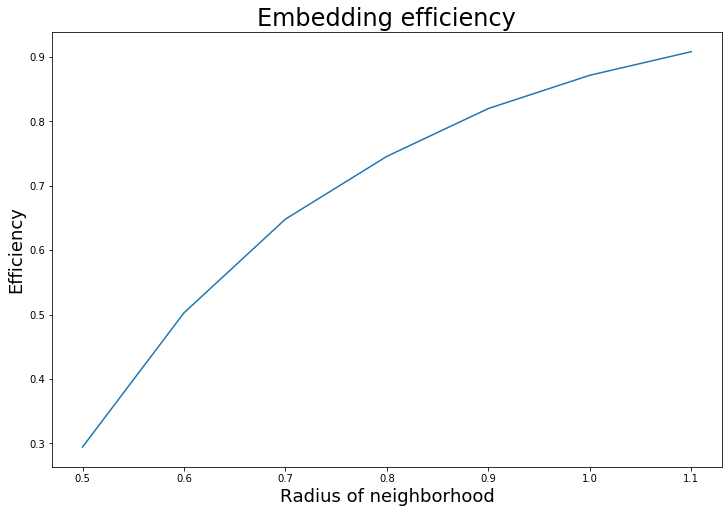

In [28]:
plt.figure(figsize=(12, 8))
plt.plot(all_radius, all_efficiencies)
plt.title("Embedding efficiency", fontsize=24), plt.xlabel(
    "Radius of neighborhood", fontsize=18
), plt.ylabel("Efficiency", fontsize=18);

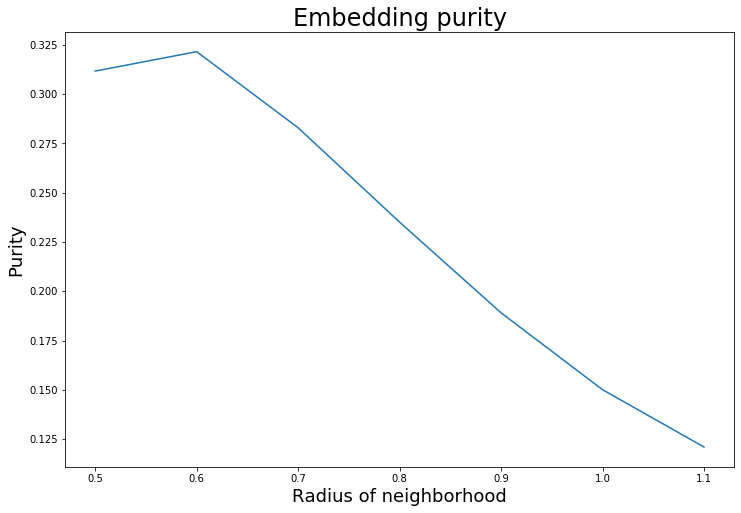

In [29]:
plt.figure(figsize=(12, 8))
plt.plot(all_radius, all_purities)
plt.title("Embedding purity", fontsize=24), plt.xlabel(
    "Radius of neighborhood", fontsize=18
), plt.ylabel("Purity", fontsize=18);

### Visualise embedding / latent space

Another useful thing to visualise is the actual space being embedded into. Since it's 8 dimensional, we can reduce it to 2 dimensions with "Principal Component Analysis". 

In [24]:
from sklearn.decomposition import PCA

In [25]:
example_data = trainset[0]
particle_ids = example_data.pid
cyl_coords = example_data.x
cell_features = example_data.cell_data
all_features = torch.cat([cyl_coords, cell_features], axis=-1).to("cuda")

In [26]:
latent_features = model(all_features)

In [27]:
pca = PCA(n_components=2)

In [28]:
reduced_dimensions = pca.fit_transform(latent_features.detach().cpu())

In [29]:
reduced_dimensions

array([[-8.95513417, -3.68551328],
       [-9.26373197, -2.57803677],
       [17.49976278,  3.70361098],
       ...,
       [16.35837063, -5.6276739 ],
       [17.72111695, -4.57634675],
       [13.94139828, -8.52278351]])

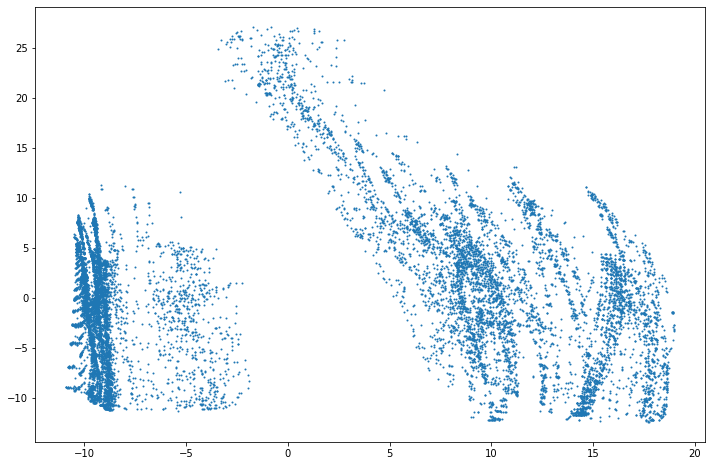

In [30]:
plt.figure(figsize=(12, 8))
plt.scatter(reduced_dimensions[:, 0], reduced_dimensions[:, 1], s=1)

The above plot is what **all** the data looks like in the latent space. Let's pick a (long) particle track and see if the track is projected to be close together:

In [31]:
particles, counts = np.unique(example_data.pid, return_counts=True)

In [32]:
example_particle = particles[counts > 10][0]

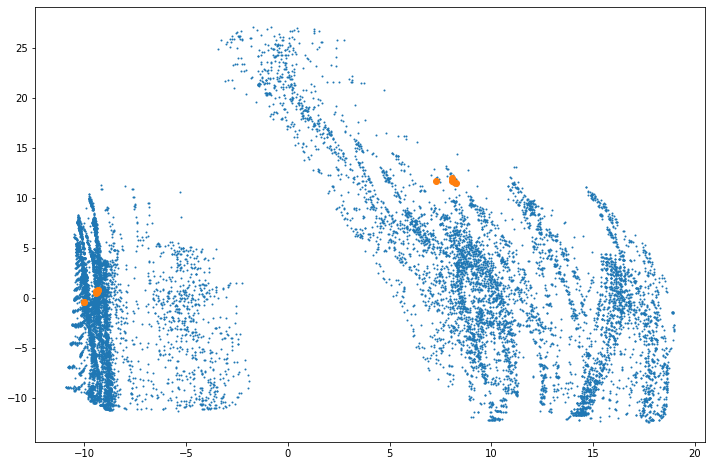

In [33]:
plt.figure(figsize=(12, 8))
plt.scatter(reduced_dimensions[:, 0], reduced_dimensions[:, 1], s=1)
plt.scatter(
    reduced_dimensions[particle_ids == example_particle, 0],
    reduced_dimensions[particle_ids == example_particle, 1],
)

There are at least 10 hits in the plot above. Hopefully some of them cluster together into blobs, and that the blobs are close to other blobs of the same color. We get ~99% efficiency with this model, so even if some blobs appear far away in the PCA-reduced 2D space, they are most likely much closer in the 8-dimensional space. You can check this yourself!

### Distributions

In [7]:
def calc_eta(r, z):
    theta = np.arctan2(r, z)
    return -1.0 * np.log(np.tan(theta / 2.0))

In [7]:
def get_performance(model, batch, r_max, k_max):
    with torch.no_grad():
        input_data = torch.cat(
            [batch.cell_data[:, : model.hparams["cell_channels"]], batch.x], axis=-1
        )
        input_data[input_data != input_data] = 0
        spatial = model(input_data)
        e_bidir = torch.cat(
            [batch.modulewise_true_edges, batch.modulewise_true_edges.flip(0)], axis=-1
        )
        e_spatial = build_edges(
            spatial, spatial, indices=None, r_max=r_max, k_max=k_max
        )
        e_spatial, y_cluster = graph_intersection(e_spatial, e_bidir)

    return y_cluster, e_spatial, e_bidir

In [37]:
r_max = 1.6
k_max = 1100

In [38]:
%%time
batch = 0
model.eval()

y_cluster, e_spatial, e_bidir = get_performance(
    model, model.testset[batch].to(device), r_max=r_max, k_max=k_max
)

CPU times: user 12.2 s, sys: 7.56 s, total: 19.8 s
Wall time: 18.9 s


In [28]:
print(
    f"Pur: {y_cluster.sum() / y_cluster.shape[0]}, Eff: {y_cluster.sum() / e_bidir.shape[1]}"
)

Pur: 0.0007887072279118001, Eff: 0.9454706311225891


In [39]:
print(
    f"Pur: {y_cluster.sum() / y_cluster.shape[0]}, Eff: {y_cluster.sum() / e_bidir.shape[1]}"
)

Pur: 0.0011381200747564435, Eff: 0.9444215893745422


In [40]:
torch.cuda.max_memory_allocated() / 1024**3

7.769199371337891

In [35]:
torch.cuda.reset_peak_memory_stats()

In [12]:
eta_cuts = np.arange(-4, 4.5, 0.5)
batch_range = np.arange(0, 200)

eta_eff_list = []
eta_pur_list = []

for batch_idx in batch_range[:5]:

    batch = model.testset[batch_idx].to(device)

    y_cluster, e_spatial, e_bidir = get_performance(
        model, batch, r_max=r_max, k_max=k_max
    )

    eta_hits = calc_eta(batch.x[:, 0].cpu(), batch.x[:, 2].cpu())
    av_eta_preds = (eta_hits[e_spatial[0]] + eta_hits[e_spatial[1]]) / 2
    av_eta_true = (eta_hits[e_bidir[0]] + eta_hits[e_bidir[1]]) / 2

    for eta1, eta2 in zip(eta_cuts[:-1], eta_cuts[1:]):
        edge_eta_pred = (av_eta_preds >= eta1) & (av_eta_preds <= eta2)
        edge_eta_true = (av_eta_true >= eta1) & (av_eta_true <= eta2)
        true_positives = y_cluster[edge_eta_pred]

        eta_eff_list.append(true_positives.sum().item() / edge_eta_true.sum().item())
        eta_pur_list.append(true_positives.sum().item() / true_positives.shape[0])

RuntimeError: CUDA out of memory. Tried to allocate 1.52 GiB (GPU 0; 15.78 GiB total capacity; 11.62 GiB already allocated; 1.49 GiB free; 12.93 GiB reserved in total by PyTorch)

In [ ]:
eta_eff_reshape = np.array(eta_eff_list).reshape(
    eta_cuts.shape[0] - 1, len(batch_range)
)
eta_pur_reshape = np.array(eta_pur_list).reshape(
    eta_cuts.shape[0] - 1, len(batch_range)
)

Train set

In [ ]:
plt.scatter(eta_eff_reshape.mean(0), eta_pur_reshape.mean(0), s=2)

Test set

In [ ]:
plt.scatter(eta_eff_reshape.mean(0), eta_pur_reshape.mean(0), s=2)

In [ ]:
eta_center = (eta_cuts[:-1] + eta_cuts[1:]) / 2
plt.errorbar(eta_center, eta_eff_reshape.mean(1), eta_eff_reshape.std(1), fmt="o")

In [ ]:
eta_center = (eta_cuts[:-1] + eta_cuts[1:]) / 2
plt.errorbar(eta_center, eta_pur_reshape.mean(1), eta_pur_reshape.std(1), fmt="o")

In [ ]:
pt_cuts = np.arange(900, 5000, 500)

pt_eff_list = []
pt_pur_list = []

for batch_idx in batch_range:

    batch = model.testset[batch_idx].to(device)

    y_cluster, e_spatial, e_bidir = get_performance(model, batch, r_max=1.2, k_max=500)

    av_pt_preds = (batch.pt[e_spatial[0]] + batch.pt[e_spatial[1]]) / 2
    av_pt_true = (batch.pt[e_bidir[0]] + batch.pt[e_bidir[1]]) / 2

    for pt1, pt2 in zip(pt_cuts[:-1], pt_cuts[1:]):
        edge_pt_pred = (av_pt_preds >= pt1) & (av_pt_preds <= pt2)
        edge_pt_true = (av_pt_true >= pt1) & (av_pt_true <= pt2)
        true_positives = y_cluster[edge_pt_pred]

        pt_eff_list.append(
            true_positives.sum().item() / max(1, edge_pt_true.sum().item())
        )
        pt_pur_list.append(
            true_positives.sum().item() / max(1, true_positives.shape[0])
        )

In [ ]:
pt_eff_reshape = np.array(pt_eff_list).reshape(pt_cuts.shape[0] - 1, len(batch_range))
pt_pur_reshape = np.array(pt_pur_list).reshape(pt_cuts.shape[0] - 1, len(batch_range))

In [ ]:
pt_center = (pt_cuts[:-1] + pt_cuts[1:]) / 2
plt.errorbar(pt_center, pt_eff_reshape.mean(1), pt_eff_reshape.std(1), fmt="o")

In [ ]:
pt_center = (pt_cuts[:-1] + pt_cuts[1:]) / 2
plt.errorbar(pt_center, pt_pur_reshape.mean(1), pt_pur_reshape.std(1), fmt="o")

## Memory of Edge Builder

In [29]:
torch.cuda.max_memory_allocated() / 1024**3

4.934445381164551

In [26]:
torch.cuda.reset_peak_memory_stats()

In [8]:
r_max = 1.6
k_max = 1000

In [9]:
batch = model.testset[0].to(device)
model.eval()
with torch.no_grad():
    input_data = torch.cat(
        [batch.cell_data[:, : model.hparams["cell_channels"]], batch.x], axis=-1
    )
    input_data[input_data != input_data] = 0
    spatial = model(input_data)
    e_bidir = torch.cat(
        [batch.modulewise_true_edges, batch.modulewise_true_edges.flip(0)], axis=-1
    )

In [11]:
dists, idxs, nn, grid = frnn.frnn_grid_points(
    points1=spatial.unsqueeze(0),
    points2=spatial.unsqueeze(0),
    lengths1=None,
    lengths2=None,
    K=k_max,
    r=r_max,
    grid=None,
    return_nn=False,
    return_sorted=True,
)

In [13]:
idxs = idxs.squeeze().int()
ind = torch.Tensor.repeat(
    torch.arange(idxs.shape[0], device=device), (idxs.shape[1], 1), 1
).T.int()

In [15]:
positive_idxs = idxs >= 0
ind = ind[positive_idxs]
idxs = idxs[positive_idxs]

In [17]:
edge_list = torch.stack([ind, idxs]).int()

In [19]:
# Remove self-loops
edge_list = edge_list[:, edge_list[0] != edge_list[1]]

In [24]:
del ind
del idxs

In [28]:
edge_list = edge_list.long()

# Build Edge Dataset

## Load best model

In [16]:
checkpoint_path = "/global/cscratch1/sd/danieltm/ExaTrkX/itk_lightning_checkpoints/ITk_1GeV/pdwlz89x/checkpoints/last.ckpt"
checkpoint = torch.load(checkpoint_path)

In [17]:
model = LayerlessEmbedding.load_from_checkpoint(checkpoint_path).to(device)

In [18]:
model.hparams["train_split"] = [10, 10, 10]

In [19]:
%%time
model.setup(stage="fit")

KeyError: 'pt_background_min'

## Define Building Class

In [7]:
class EmbeddingInferenceBuilder:
    def __init__(self, model, output_dir, overwrite=False):
        self.output_dir = output_dir
        self.model = model
        self.overwrite = overwrite

        # Prep the directory to produce inference data to
        self.datatypes = ["train", "val", "test"]
        os.makedirs(self.output_dir, exist_ok=True)
        [
            os.makedirs(os.path.join(self.output_dir, datatype), exist_ok=True)
            for datatype in self.datatypes
        ]

    def build(self):
        print("Training finished, running inference to build graphs...")

        # By default, the set of examples propagated through the pipeline will be train+val+test set
        datasets = {
            "train": self.model.trainset,
            "val": self.model.valset,
            "test": self.model.testset,
        }
        total_length = sum([len(dataset) for dataset in datasets.values()])
        batch_incr = 0
        self.model.eval()
        with torch.no_grad():
            for set_idx, (datatype, dataset) in enumerate(datasets.items()):
                for batch_idx, batch in enumerate(dataset):
                    percent = (batch_incr / total_length) * 100
                    sys.stdout.flush()
                    sys.stdout.write(f"{percent:.01f}% inference complete \r")
                    if (
                        not os.path.exists(
                            os.path.join(
                                self.output_dir, datatype, batch.event_file[-4:]
                            )
                        )
                    ) or self.overwrite:
                        batch_to_save = copy.deepcopy(batch)
                        batch_to_save = batch_to_save.to(
                            self.model.device
                        )  # Is this step necessary??
                        self.construct_downstream(batch_to_save, datatype)

                    batch_incr += 1

    def construct_downstream(self, batch, datatype):

        if "ci" in self.model.hparams["regime"]:
            input_data = torch.cat(
                [batch.cell_data[:, : self.model.hparams["cell_channels"]], batch.x],
                axis=-1,
            )
            input_data[input_data != input_data] = 0
            spatial = self.model(input_data)
        else:
            input_data = batch.x
            input_data[input_data != input_data] = 0
            spatial = self.model(input_data)

        # Make truth bidirectional
        e_bidir = torch.cat(
            [
                batch.modulewise_true_edges,
                torch.stack(
                    [batch.modulewise_true_edges[1], batch.modulewise_true_edges[0]],
                    axis=1,
                ).T,
            ],
            axis=-1,
        )

        # Build the radius graph with radius < r_test
        e_spatial = build_edges(
            spatial,
            spatial,
            indices=None,
            r_max=self.model.hparams["r_test"],
            k_max=1100,
        ).long()  # This step should remove reliance on r_val, and instead compute an r_build based on the EXACT r required to reach target eff/pur

        # Arbitrary ordering to remove half of the duplicate edges
        R_dist = torch.sqrt(batch.x[:, 0] ** 2 + batch.x[:, 2] ** 2)
        e_spatial = e_spatial[:, (R_dist[e_spatial[0]] <= R_dist[e_spatial[1]])]

        e_spatial, y_cluster = graph_intersection(e_spatial, e_bidir)

        # Re-introduce random direction, to avoid training bias
        random_flip = torch.randint(2, (e_spatial.shape[1],)).bool()
        e_spatial[0, random_flip], e_spatial[1, random_flip] = (
            e_spatial[1, random_flip],
            e_spatial[0, random_flip],
        )

        batch.edge_index = e_spatial
        batch.y = y_cluster

        self.save_downstream(batch, datatype)

    def save_downstream(self, batch, datatype):

        with open(
            os.path.join(self.output_dir, datatype, batch.event_file[-4:]), "wb"
        ) as pickle_file:
            torch.save(batch, pickle_file)

In [10]:
output_dir = "/project/projectdirs/m3443/data/ITk-upgrade/processed/embedding_processed/0_GeV_unweighted_subset"
model.hparams["r_test"] = 1.6
edge_builder = EmbeddingInferenceBuilder(model, output_dir, overwrite=False)

In [11]:
edge_builder.build()

Training finished, running inference to build graphs...


In [13]:
len(model.trainset)

100